In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 5]
plt.rcParams['axes.grid'] = True
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
from sklearn.metrics import roc_auc_score
font = {'family' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
pd.set_option('display.max_rows', 200)
pd.set_option('precision', 4)

# Part 1 - Exploratory Data Analysis

- Explore the whole dataset and find any interesting insights
- Evaluate the data quality and figure out whether outliers exist.
- Select the strongest predictors and perform feature engineering

Total number of samples: 10,000

We begin the study by analyzing each of the features present individually for

* Data Assessment:
    * What does the data look like? 
    * Are there any quality issues? 
    * Is the data integrity good enough to be relied on?
* Any low hanging fruits in terms of insights, 
* Quantify strength as a predictor.

Then we can start looking at features cross-sectionally.

**NOTE**: If this were to be placed in production, we'd have to take into account the fact that some features can be discriminatory against a client. Features such as sex and age, for example, shouldn't be taken into account when predicting defaults. However, for this exercise we will proceed disregarding this note.

# Data Description

| Data | Definition | Value(s) |
| --- | --- | --- |
| ID | ID of each client | |
| LIMIT_BAL | Amount of given credit in NT dollars (includes individual and family/supplementary credit | |
| SEX | Gender | (1=male, 2=female) |
| EDUCATION | Education | (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) |
| MARRIAGE | Marital status | (1=married, 2=single, 3=others) |
| AGE | Age in years | |
| PAY_0 | Repayment status in September, 2005 | (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above) |
| PAY_2 | Repayment status in August, 2005 | (scale same as above) |
| PAY_3 | Repayment status in July, 2005 | (scale same as above) |
| PAY_4 | Repayment status in June, 2005 | (scale same as above) |
| PAY_5 | Repayment status in May, 2005 | (scale same as above) |
| PAY_6 | Repayment status in April, 2005 | (scale same as above) |
| BILL_AMT1 | Amount of bill statement in September, 2005 (NT dollar) | |
| BILL_AMT2 | Amount of bill statement in August, 2005 (NT dollar) | |
| BILL_AMT3 | Amount of bill statement in July, 2005 (NT dollar) | |
| BILL_AMT4 | Amount of bill statement in June, 2005 (NT dollar) | |
| BILL_AMT5 | Amount of bill statement in May, 2005 (NT dollar) | |
| BILL_AMT6 | Amount of bill statement in April, 2005 (NT dollar) | |
| PAY_AMT1 | Amount of previous payment in September, 2005 (NT dollar) | |
| PAY_AMT2 | Amount of previous payment in August, 2005 (NT dollar) | |
| PAY_AMT3 | Amount of previous payment in July, 2005 (NT dollar) | |
| PAY_AMT4 | Amount of previous payment in June, 2005 (NT dollar) | |
| PAY_AMT5 | Amount of previous payment in May, 2005 (NT dollar) | |
| PAY_AMT6 | Amount of previous payment in April, 2005 (NT dollar) | |
| default.payment.next.month | Default payment | (1=yes, 0=no) | |

In [2]:
# Load data
data = pd.read_csv('../dataset/data.csv', index_col=0)
data.rename({'default.payment.next.month': 'default'}, axis=1, inplace=True)
data.default = data.default.astype(bool)

In [3]:
# See label distribution
paid = data[data['default']==0]
default = data[data['default']==1]
print("How imbalanced is the dataset?\n")
print(f"Paid: \t\t {len(paid)}")
print(f"Defaults: \t {len(default)}")

How imbalanced is the dataset?

Paid: 		 7762
Defaults: 	 2238


A brief look lets us categorize the features as follows.

CATEGORICAL:

* AGE
* EDUCATION
* MARRIAGE
* SEX
* PAY_# (1-6) # Pay may be the number of days way from t, the due date of payment.

CONTINUOUS:

* BILL_AMT# (1-6)
* PAY_AMT# (1-6)
* LIMIT_BAL

## Feature Correlations

Let's see how correlated the variables are to each other and to the target `default`.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


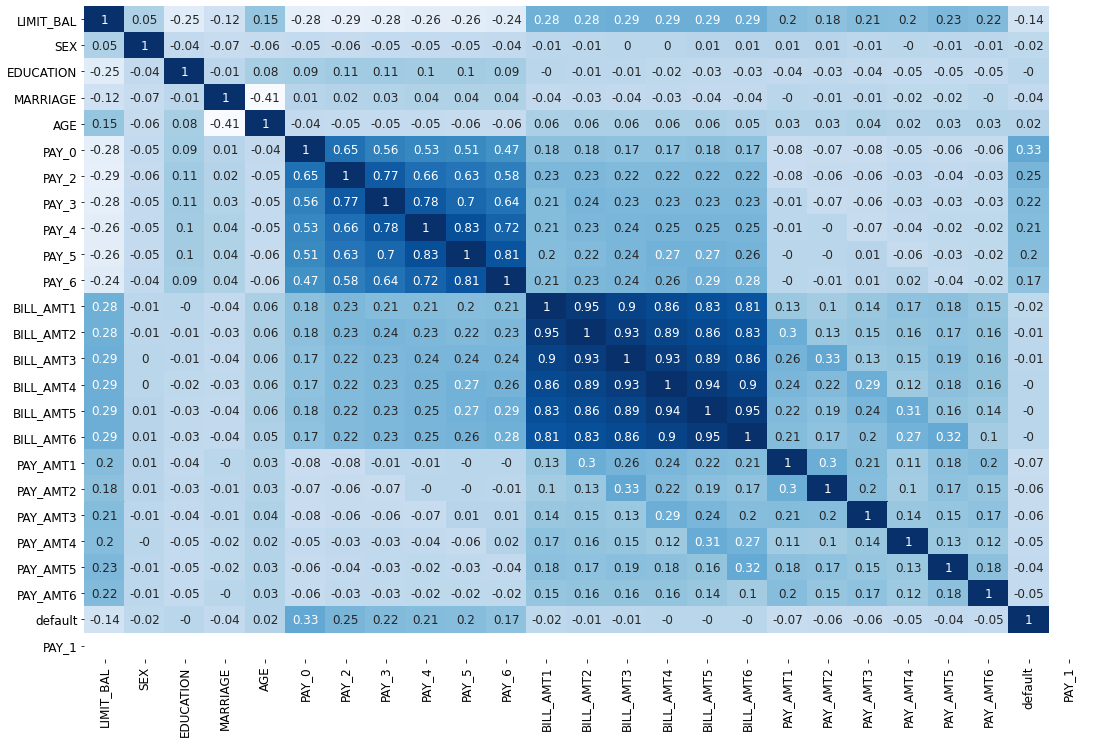

In [4]:
plt.figure(figsize=(18, 12))
sns.heatmap(np.round(data.corr(), 2), cmap='Blues', cbar=False, annot=True);

In [5]:
## On closer inspection....
data.corr()['default'].drop('default').sort_values()

LIMIT_BAL   -0.1426
PAY_AMT1    -0.0690
PAY_AMT2    -0.0632
PAY_AMT3    -0.0605
PAY_AMT4    -0.0540
PAY_AMT6    -0.0489
PAY_AMT5    -0.0408
MARRIAGE    -0.0393
SEX         -0.0235
BILL_AMT1   -0.0156
BILL_AMT3   -0.0116
BILL_AMT2   -0.0098
BILL_AMT5   -0.0033
EDUCATION   -0.0031
BILL_AMT4   -0.0030
BILL_AMT6   -0.0028
AGE          0.0197
PAY_6        0.1663
PAY_5        0.2020
PAY_4        0.2070
PAY_3        0.2198
PAY_2        0.2494
PAY_0        0.3258
PAY_1           NaN
Name: default, dtype: float64

Immediate observations are:
* Month on Month Bill amounts and payments are related for a given individual - as expected.
* Limit balance is also positively correlated with bill amount and payment amount - as expected.
* Payment status is somewhat correlated with default rates - specifically the last payment status (September).
* Pay amounts are somewhat negatively correlated with the default rate, as is the limit balance.
    * The greater the limit balance, the less likely it is for an individual to respond. Going hard on the DD!

## Duplicates

It is sensible for us to see if there are any duplicates in the data.

In [6]:
dups = data[data.duplicated()]
print('Number of duplicates: ', len(dups))
unique_dups = dups.drop_duplicates()
print('Number of unique duplicates: ', len(unique_dups))

Number of duplicates:  105
Number of unique duplicates:  7


In [7]:
unique_dups.T

ID,360,3535,4490,5147,7392,7821,7963
LIMIT_BAL,1000,3.6e+05,3.6e+05,1.5e+05,2e+04,8e+04,1e+05
SEX,1,2,2,2,1,2,2
EDUCATION,6,1,1,1,2,2,2
MARRIAGE,3,1,2,1,2,1,1
AGE,18,41,27,31,24,31,49
PAY_0,0,-2,1,1,2,-2,1
PAY_2,0,-2,-2,-2,2,-2,-2
PAY_3,0,-2,-2,-2,4,-2,-2
PAY_4,0,-2,-2,-2,4,-2,-2
PAY_5,0,-2,-2,-2,4,-2,-2


It is difficult to tell whether these are by accident or not, as these come from cards that were seldom used.
Therefore, we will not remove the duplicated values.

## Null Values

In [8]:
data.isna().sum()

LIMIT_BAL       0
SEX             0
EDUCATION       0
MARRIAGE        0
AGE             0
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1       0
BILL_AMT2       0
BILL_AMT3       0
BILL_AMT4       0
BILL_AMT5       0
BILL_AMT6       0
PAY_AMT1        0
PAY_AMT2        0
PAY_AMT3        0
PAY_AMT4        0
PAY_AMT5        0
PAY_AMT6        0
default         0
PAY_1        9900
dtype: int64

Only PAY_1 has nulls. 

In [9]:
pay1 = data[['default', 'PAY_1']].dropna()
pd.crosstab(pay1.default, pay1.PAY_1)

PAY_1,0.0
default,
False,100


100% of PAY_1s are False. Good indicator of a no-default.
Therefore, we fill the PAY_1 NaNs with 1s, as all the values that do exist are 0.

In [10]:
data['PAY_1'].fillna(1, inplace=True)

# Bills Paid = 0 and PAY_AMT = 0

If an individual has Bill Paid = 0 and Pay Amount = 0 for all time periods, the individual
either didn't use the card, or paid the balance immediately (which might as well mean that they 
didn't use credit). This corresponds to PAY_ of -2.

So, what does it mean when an individual defaults but didn't use the card? Likely faulty data...?

In [11]:
print('Paid individuals that did not use their card: \t\t', round(paid[(paid.filter(like='BILL') == 0).all(axis=1)].shape[0]))

print('Defaulted individuals that did not use their card: \t', round(default[(default.filter(like='BILL') == 0).all(axis=1)].shape[0]))

Paid individuals that did not use their card: 		 187
Defaulted individuals that did not use their card: 	 117


In [12]:
paid[(paid.filter(like='BILL') == 0).all(axis=1)].head(15).T

ID,19,49,58,87,127,165,186,201,229,372,410,487,524,728,790
LIMIT_BAL,1.3e+05,2e+04,1.7e+05,2.4e+05,3.6e+05,8e+04,5e+04,2.4e+05,1e+05,3.6e+05,1.8e+05,3e+05,4.5e+05,2.1e+05,2.4e+05
SEX,1,1,2,2,2,2,2,1,2,2,2,1,2,2,2
EDUCATION,1,2,1,1,1,1,2,2,3,3,1,2,1,1,2
MARRIAGE,2,1,1,2,2,1,2,2,1,2,2,1,3,2,1
AGE,25,45,31,33,27,50,28,27,53,27,27,48,37,33,37
PAY_0,1,-2,1,-2,1,1,1,1,1,1,-2,1,1,-2,1
PAY_2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
PAY_3,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
PAY_4,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
PAY_5,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2


In [13]:
# Payment status of -2 means the individual didn't use their card for the duration of the month.
data[(data.loc[:,[x for x in data.filter(like='PAY') if 'AMT' not in x]] == -2).any(axis=1)].head(10).T

ID,5,7,16,19,24,25,30,34,38,48
LIMIT_BAL,3.6e+05,1.2e+05,5.5e+05,1.3e+05,2.2e+05,5e+05,2.6e+05,4.5e+05,1e+04,1.5e+05
SEX,2,1,1,1,1,1,2,2,2,2
EDUCATION,1,1,1,1,1,1,3,1,3,1
MARRIAGE,1,1,2,2,1,1,2,2,1,2
AGE,41,51,31,25,42,59,49,38,51,34
PAY_0,-2,1,1,1,1,-2,-2,0,2,-2
PAY_2,-2,-2,2,-2,-2,-2,-2,-1,2,-2
PAY_3,-2,-2,2,-2,-2,-2,-2,-1,-2,-2
PAY_4,-2,-1,-2,-2,-2,-2,-2,-1,-2,-2
PAY_5,-2,0,-1,-2,-2,-2,-2,-1,-2,-2


# Negative Valued Bill_AMTs or PAY_AMTs 

In [81]:
print("Are there any paid amounts less than 0?", 
      any(data.filter(like="PAY_AMT").describe().loc['min']<0))

Are there any paid amounts less than 0? False


In [82]:
print("Are there any bill amounts less than 0?")
data.filter(like="BILL_AMT").describe().loc['min']

Are there any bill amounts less than 0?


BILL_AMT1   -154973.0
BILL_AMT2    -67526.0
BILL_AMT3    -34041.0
BILL_AMT4   -170000.0
BILL_AMT5    -37594.0
BILL_AMT6   -339603.0
Name: min, dtype: float64

In [85]:
print("Number of negative bill amounts per user (paid more than bill / got a refund): ")
display((data.filter(like='BILL_AMT')<0).sum(axis=1).value_counts())

Number of negative bill amounts per user (paid more than bill / got a refund): 


0    9356
1     343
2     140
3      73
4      34
6      28
5      26
dtype: int64

<AxesSubplot:>

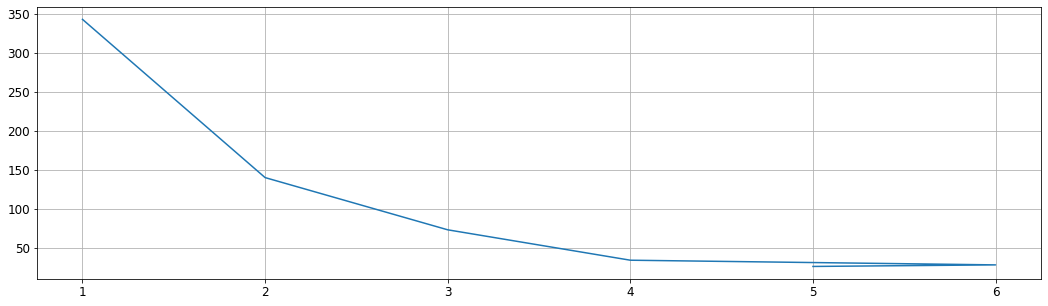

In [86]:
# Interestingly, follows Benford's law!
(data[(data.filter(like='BILL_AMT')<0).any(axis=1)].filter(like='BILL_AMT')<0).sum(axis=1).value_counts().plot()

##### Of these users, how many default?

In [18]:
pd.crosstab((data.filter(like='BILL_')<0).sum(axis=1), data.default, normalize='columns')

default,False,True
row_0,,
0,0.9295,0.9567
1,0.0389,0.0183
2,0.0152,0.0098
3,0.0082,0.0040
4,0.0035,0.0031
5,0.0024,0.0031
6,0.0022,0.0049


As expected, users that never have a negative balance have a higher proportion of defaults than users who 
sometimes have a negative balance. Paying extra or getting refunds helps determine defaults.

#### How many users pass their limit balance X times?

In [19]:
data.filter(like='BILL_AMT').gt(data['LIMIT_BAL'], axis=0).sum(axis=1).value_counts()

0    8735
1     567
2     330
3     168
4      90
6      62
5      48
dtype: int64

##### Of these users, what are the odds they default if they pass their limit balance X times?

In [20]:
pd.crosstab(data.filter(like='BILL_AMT').gt(data['LIMIT_BAL'], axis=0).sum(axis=1), data.default, normalize='columns')

default,False,True
row_0,,
0,0.8893,0.8186
1,0.0508,0.0773
2,0.0286,0.0483
3,0.0140,0.0264
4,0.0070,0.0161
5,0.0049,0.0045
6,0.0054,0.0089


As expected, the non-defaults have a higher chance of not exceeding their limit balance than the defaults.
Specifically, of the non-defaulted accounts, 88.9% don't exceed their limit balance whereas only 81% of defaulted users do.

# Helper Functions

In [21]:
from IPython.display import display

In [22]:
def show_distribution_from_range(colname, show_stats=False, quantile_clip=None):
    desc = data.pivot_table(index='ID', values=colname, columns='default').describe()
    desc.columns = desc.columns.astype(bool)
    if show_stats: display(desc)
    
    if quantile_clip:
        max_clip = data[colname].quantile(quantile_clip)
        sns.distplot(paid[colname].clip(upper=max_clip), label='Paid', norm_hist=False);
        sns.distplot(default[colname].clip(upper=max_clip), label='Defaulted', norm_hist=False);
    else:
        sns.distplot(paid[colname], label='Paid', norm_hist=False);
        sns.distplot(default[colname], label='Defaulted', norm_hist=False);
    plt.legend();

In [23]:
def explore_discrete_stats(colname, show_stats=False):
    if show_stats:
        print("Total Distribution:")
        display(pd.crosstab(data.default, data[colname], margins=True, margins_name='TOTAL'))
        print("Percent Distribution From The Whole:")
        display(pd.crosstab(data.default, data[colname], normalize='all', margins=True, margins_name='TOTAL')*100)
        print("Percent Distribution From Each Label:")
        display(pd.crosstab(data.default, data[colname], normalize='index', margins=True, margins_name='TOTAL')*100)
    pd.crosstab(data.default, data[colname], normalize='index').T.plot(marker='o');

# Age

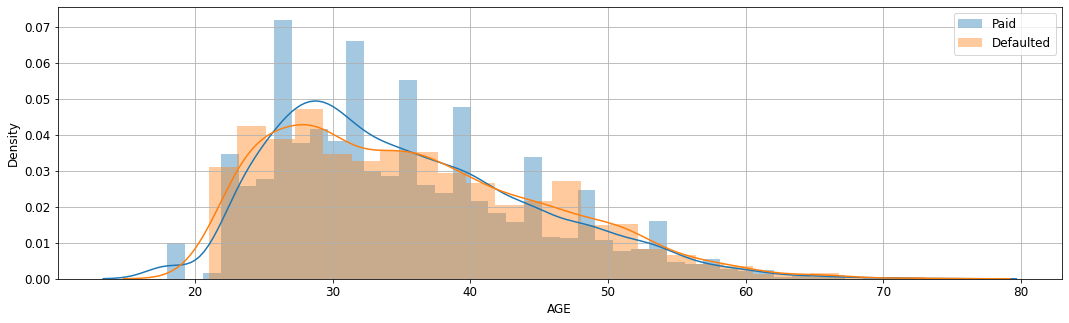

In [25]:
show_distribution_from_range('AGE')

In [26]:
print("Number of 18 unique 18 year olds: ",len(data[data.AGE==18].drop_duplicates()))

Number of 18 unique 18 year olds:  1


<AxesSubplot:xlabel='AGE', ylabel='Density'>

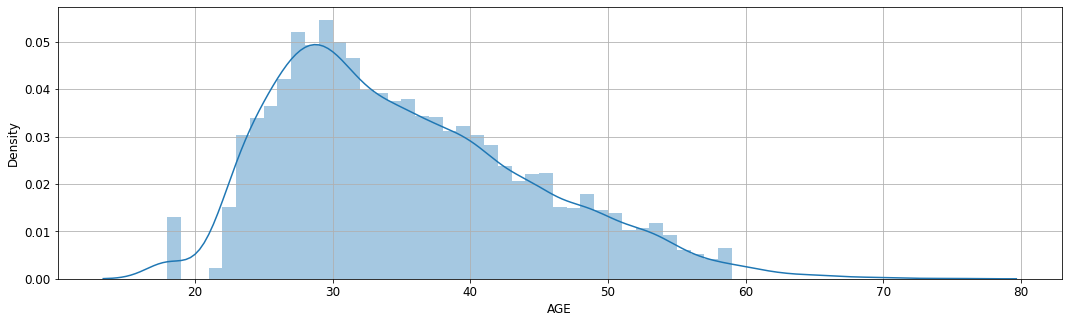

In [27]:
sns.distplot(paid['AGE'], bins=range(18, 60))

# Categorical Vars

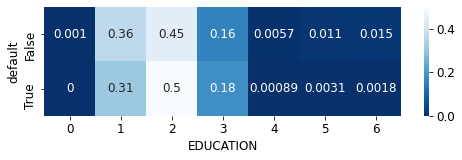

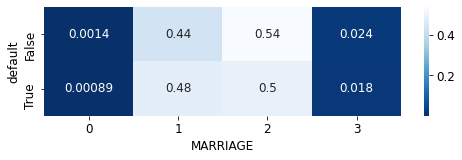

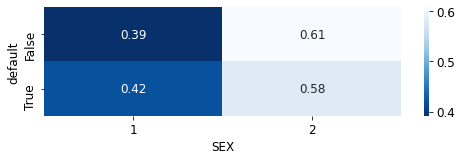

In [28]:
plt.figure(figsize=(8, 2))
sns.heatmap(pd.crosstab(data.default, data.EDUCATION, normalize='index'), cmap='Blues_r', annot=True);

plt.figure(figsize=(8, 2))
sns.heatmap(pd.crosstab(data.default, data.MARRIAGE, normalize='index'), cmap='Blues_r', annot=True);

plt.figure(figsize=(8, 2))
sns.heatmap(pd.crosstab(data.default, data.SEX, normalize='index'), cmap='Blues_r', annot=True);

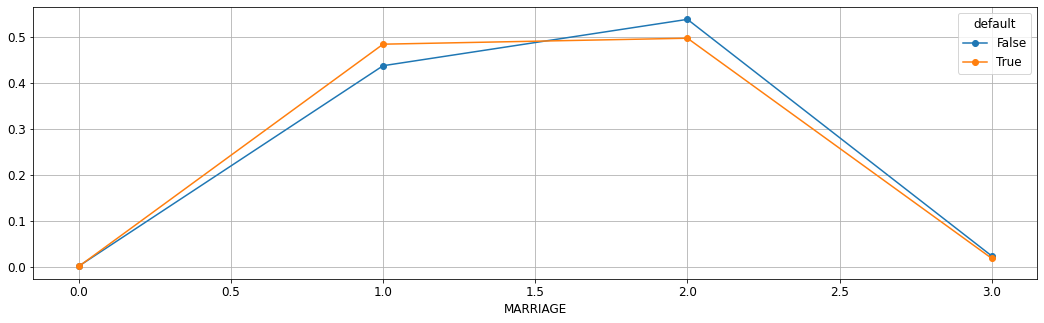

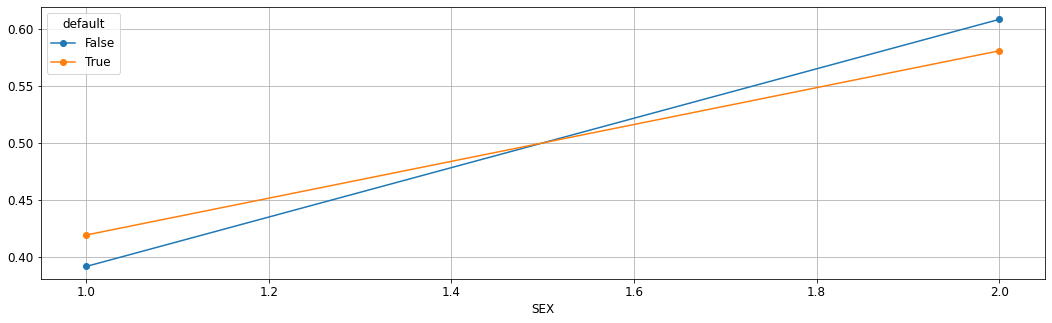

In [29]:
explore_discrete_stats("MARRIAGE")
plt.plot()
explore_discrete_stats('SEX')

# Education
For some reason, Education has 4, 5, 6, and 0 as other, even though there are 4 distinct categories. 
We relabel these as 4, as per the description.
We could leave them as they may be useful for our model, but because we strive to have model explainability, we'll label them all as "other".

In [30]:
data['EDUCATION'] = data['EDUCATION'].replace(5, 4).replace(6, 4).replace(0, 4)

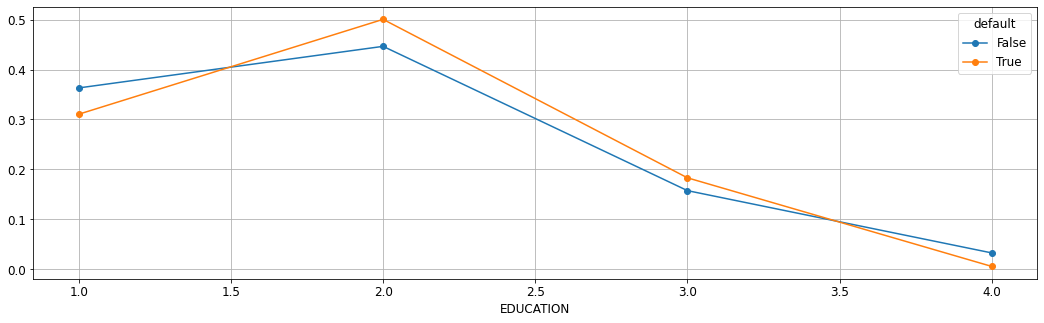

In [31]:
explore_discrete_stats("EDUCATION")
plt.plot();

# Marriage

Marriage has a value of 0 which is not in the description. For sake of explainability, we'll also label it as 'other'.

In [32]:
data['MARRIAGE'] = data['MARRIAGE'].replace(0, 3)

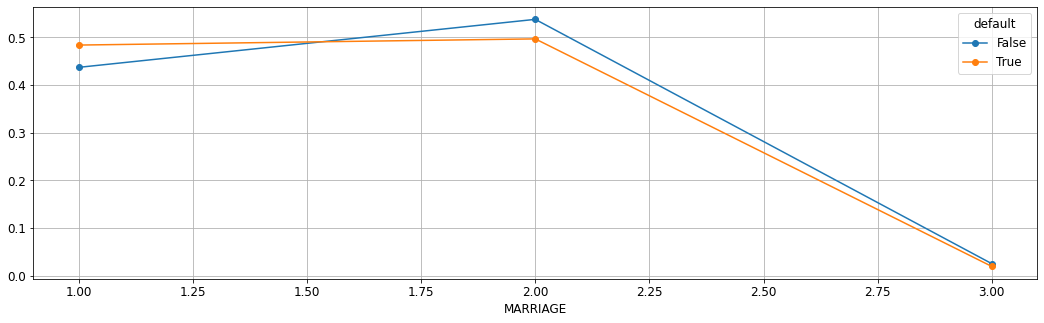

In [33]:
explore_discrete_stats("MARRIAGE")
plt.plot();

# Pay_1

In [34]:
pd.crosstab(data.PAY_1, data.default)

default,False,True
PAY_1,,
0.0,100,0
1.0,7662,2238


# PAY_

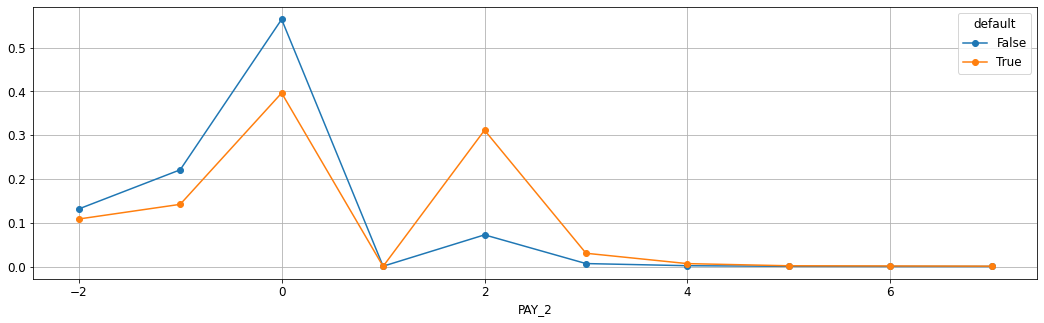

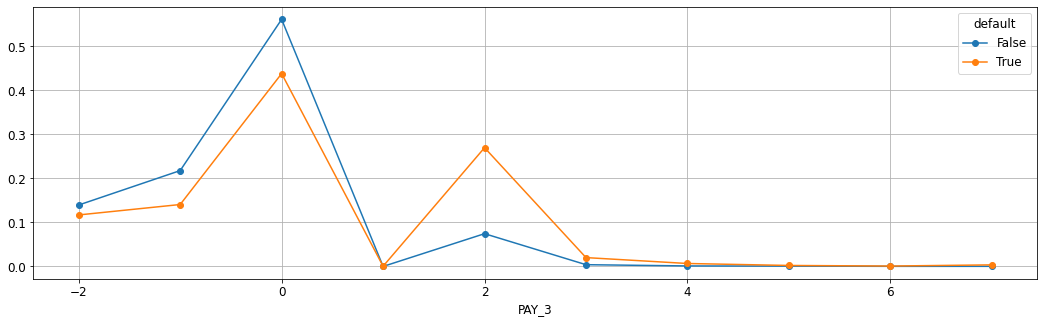

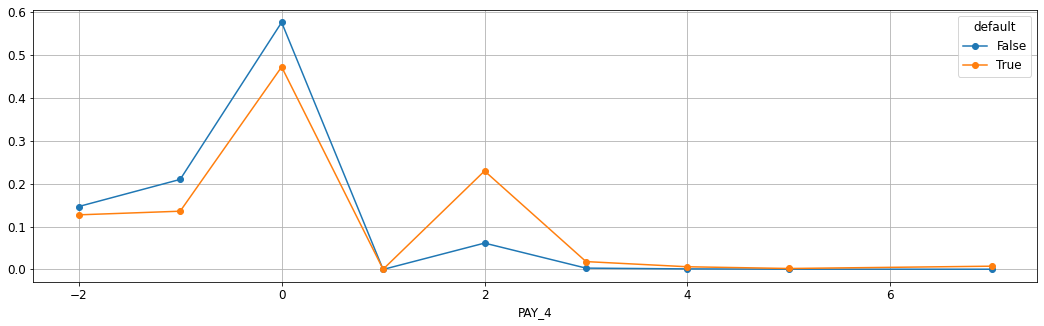

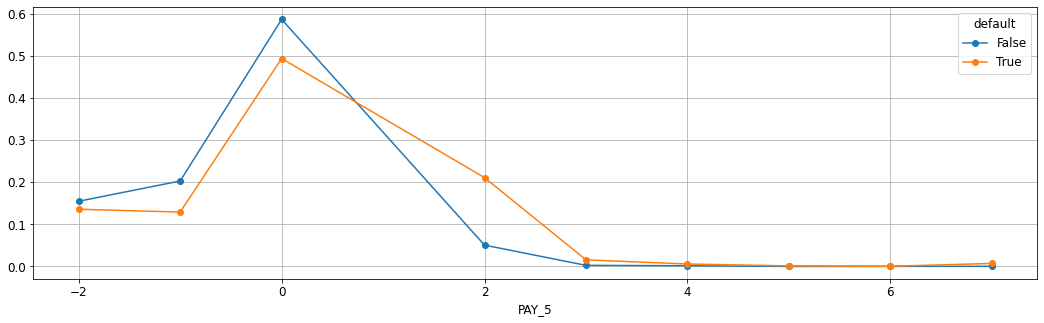

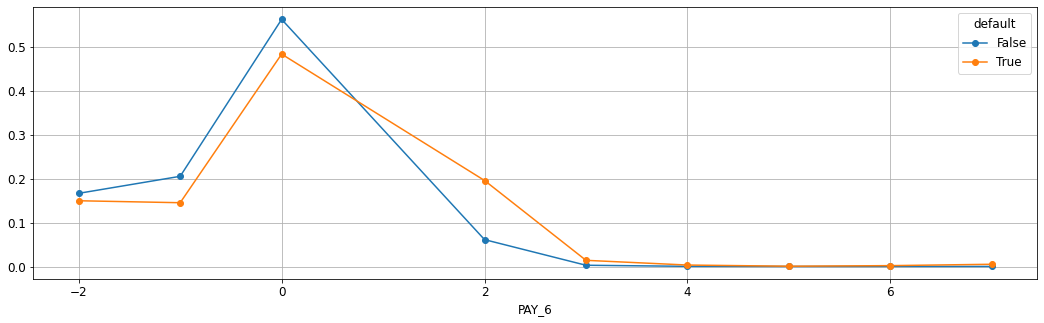

In [35]:
explore_discrete_stats('PAY_2')
explore_discrete_stats('PAY_3')
explore_discrete_stats('PAY_4')
explore_discrete_stats('PAY_5')
explore_discrete_stats('PAY_6')

Not sure why only PAY_5 and PAY_6 have values of 1.
Also not sure what values of 0 mean, as -1 is to pay duly and 1 is to be delayed for one month.
    We can assume a value of 0 means it is paid when requested.

# Pay_AMTs

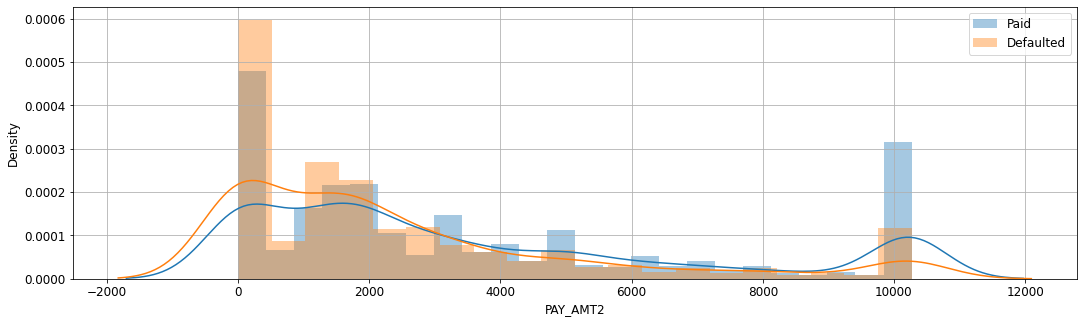

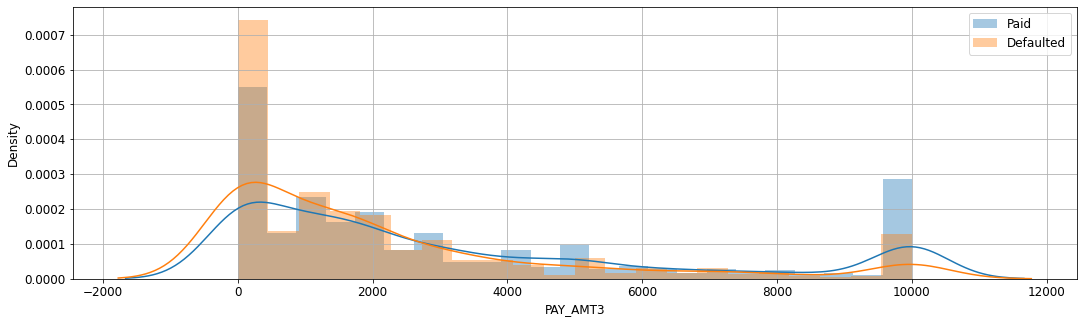

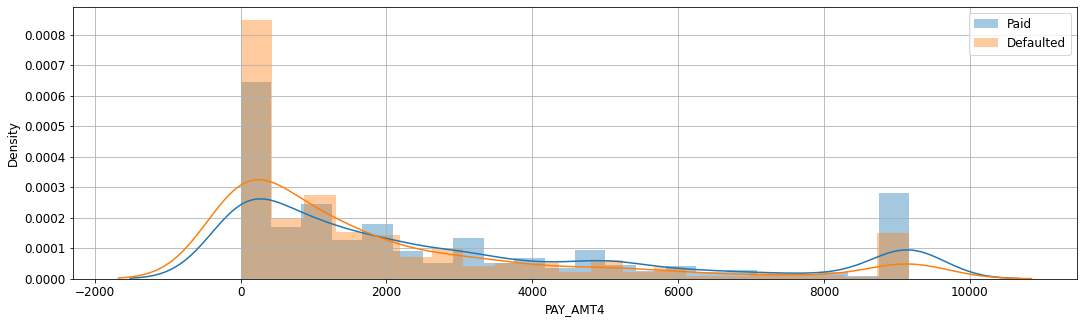

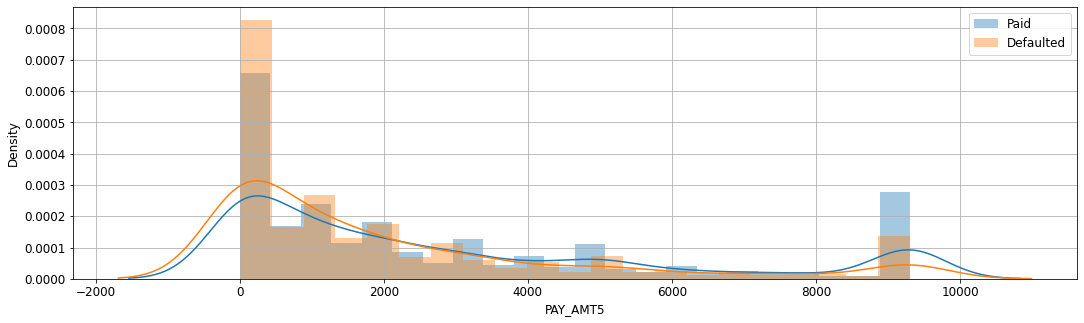

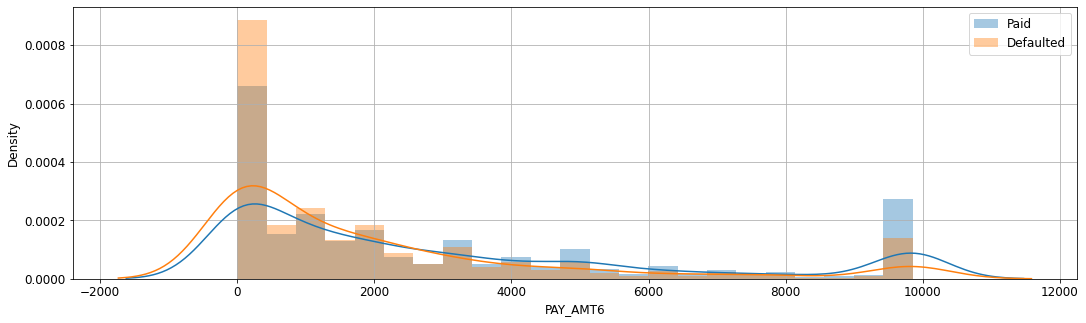

In [36]:
show_distribution_from_range('PAY_AMT2', quantile_clip=0.90);
plt.show()
show_distribution_from_range('PAY_AMT3', quantile_clip=0.90);
plt.show()
show_distribution_from_range('PAY_AMT4', quantile_clip=0.90);
plt.show()
show_distribution_from_range('PAY_AMT5', quantile_clip=0.90);
plt.show()
show_distribution_from_range('PAY_AMT6', quantile_clip=0.90);

# Bill Amounts

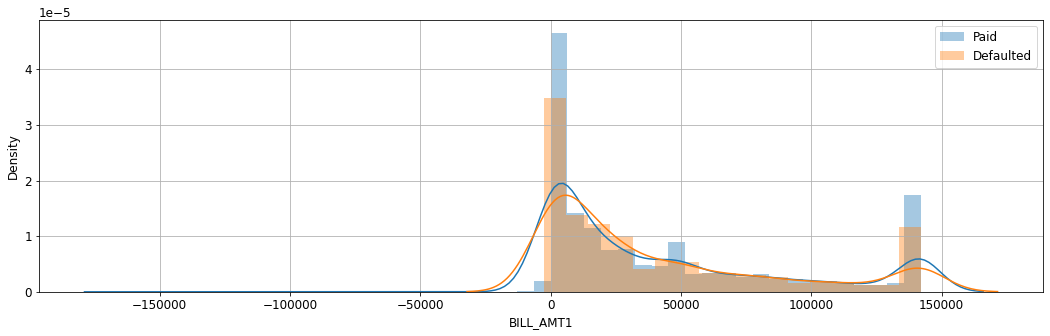

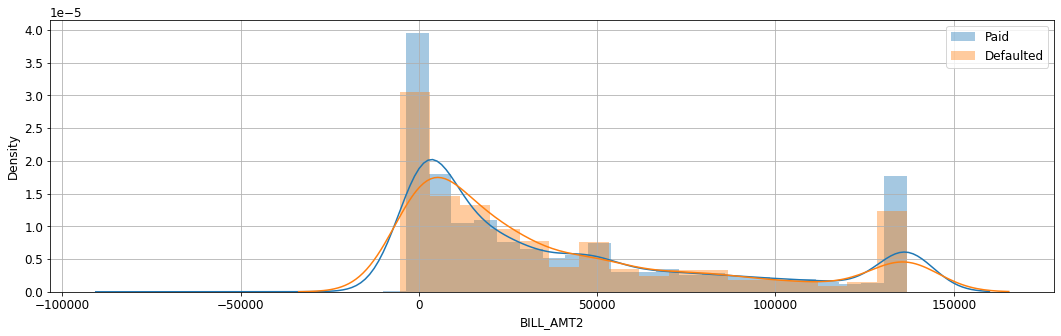

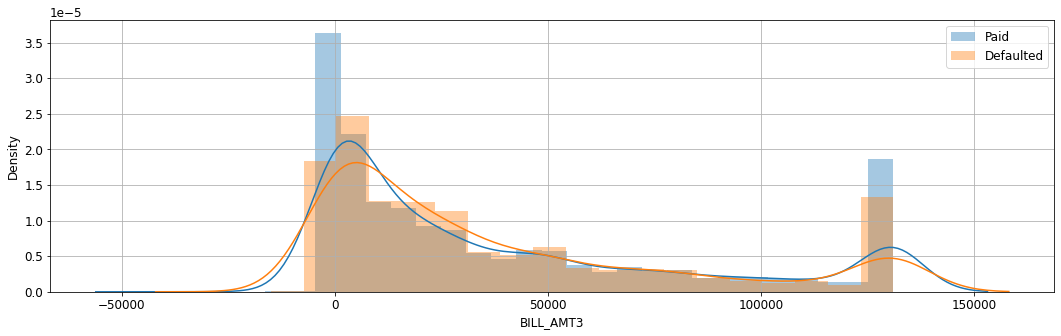

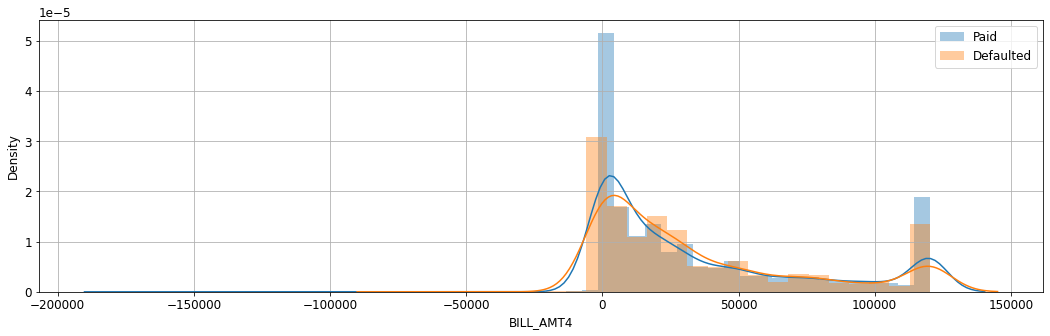

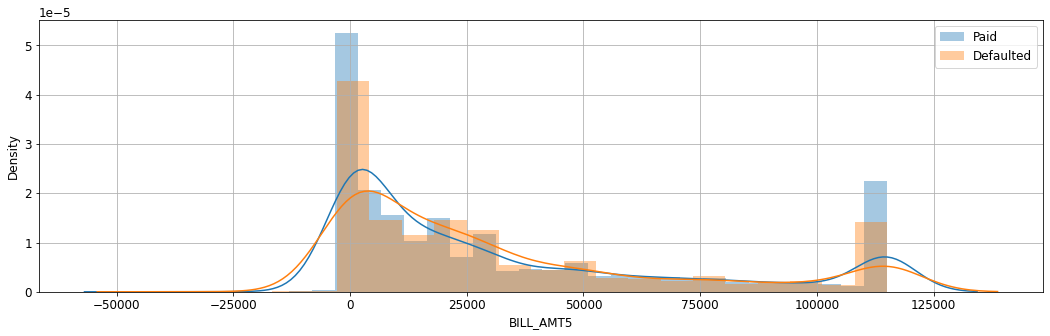

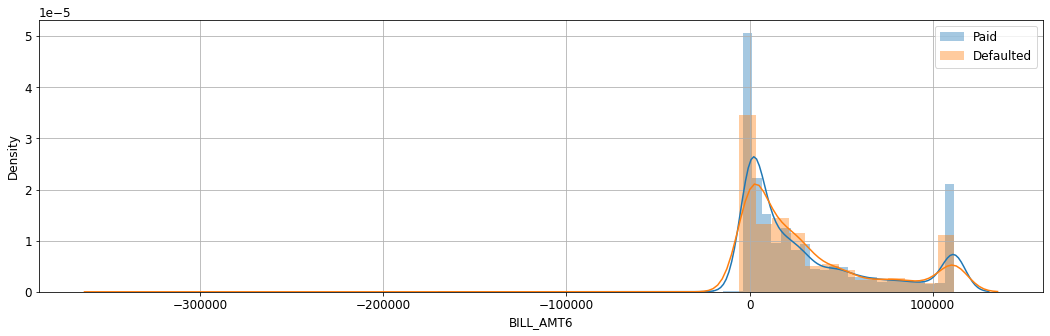

In [37]:
show_distribution_from_range('BILL_AMT1', quantile_clip=0.90);
plt.show()
show_distribution_from_range('BILL_AMT2', quantile_clip=0.90);
plt.show()
show_distribution_from_range('BILL_AMT3', quantile_clip=0.90);
plt.show()
show_distribution_from_range('BILL_AMT4', quantile_clip=0.90);
plt.show()
show_distribution_from_range('BILL_AMT5', quantile_clip=0.90);
plt.show()
show_distribution_from_range('BILL_AMT6', quantile_clip=0.90);

## Notice the log distributions of BILL_AMTs and PAY_AMTs

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


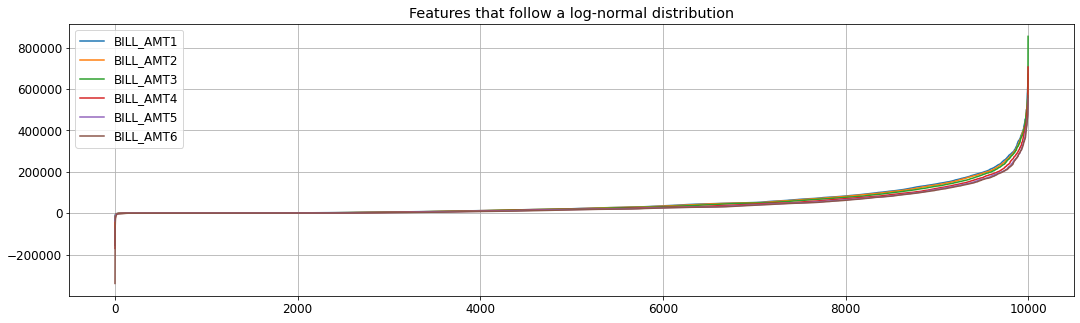

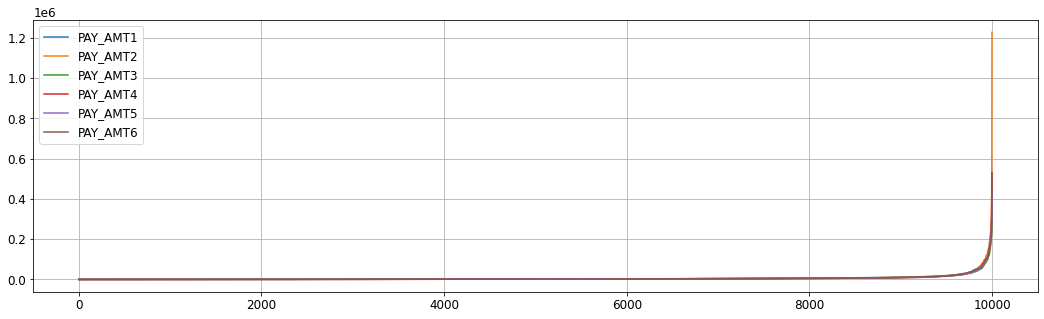

In [38]:
for b in [x for x in data.columns if 'BILL' in x]:
    data[b].sort_values().reset_index(drop=True).plot()
plt.legend();
plt.title("Features that follow a log-normal distribution")

plt.show()
for b in [x for x in data.columns if 'PAY_AMT' in x]:
    data[b].sort_values().reset_index(drop=True).plot()
plt.legend();

# Limit Balance


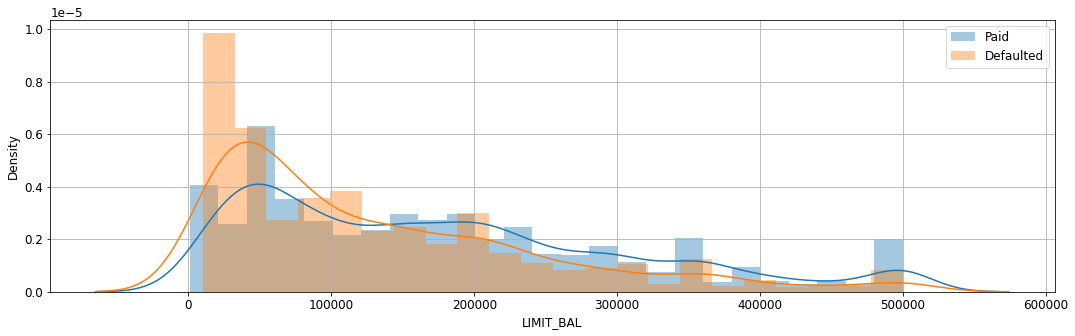

In [39]:
show_distribution_from_range('LIMIT_BAL', quantile_clip=0.99);

# Multiple Feature Explorations

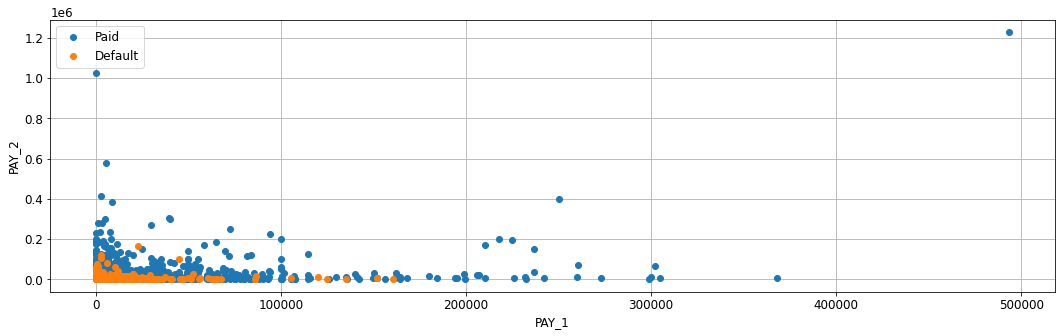

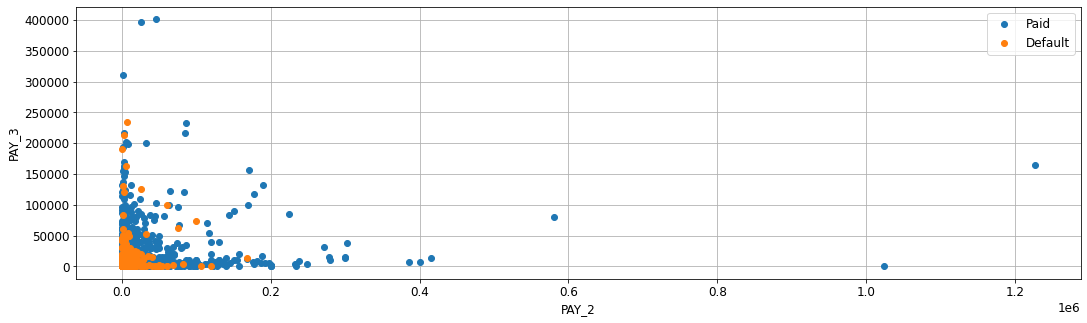

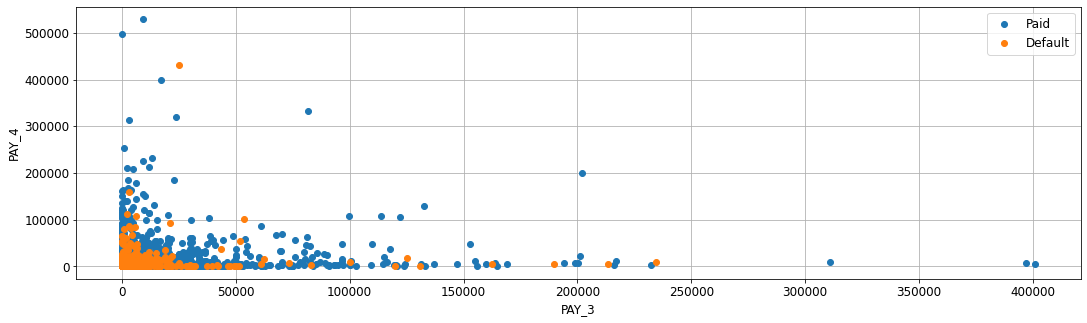

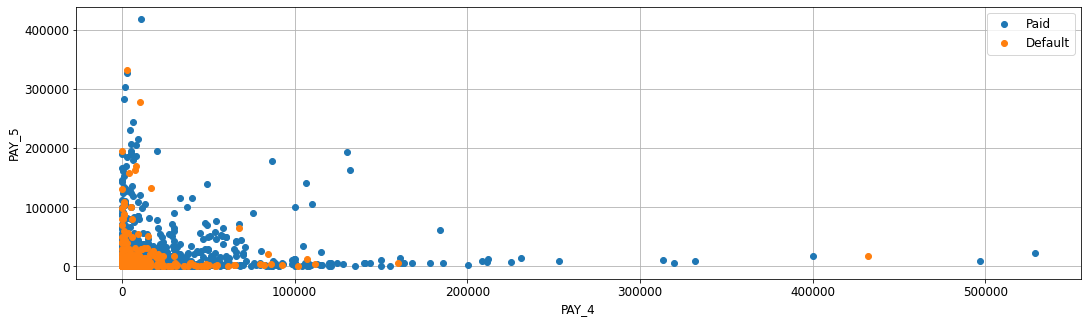

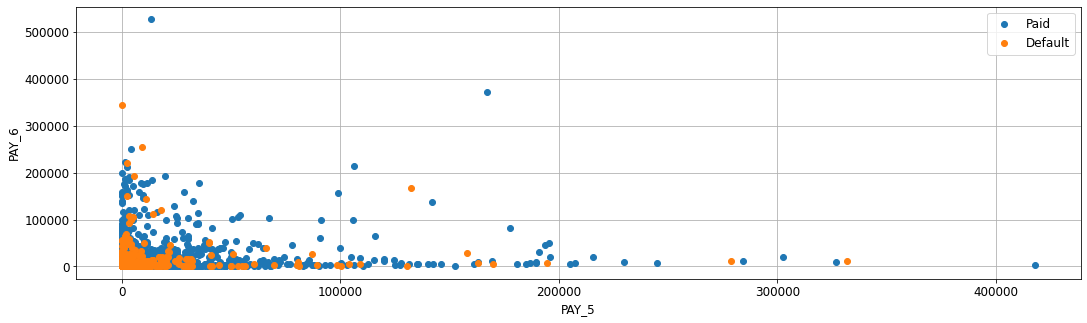

In [40]:
for i in range(1,6):
    paid.set_index(f"PAY_AMT{i}")[f'PAY_AMT{i+1}'].plot(marker='o', linestyle='', label='Paid')
    default.set_index(f"PAY_AMT{i}")[f'PAY_AMT{i+1}'].plot(marker='o', linestyle='', label='Default')
    plt.xlabel(f'PAY_{i}')
    plt.ylabel(f'PAY_{i+1}')
    plt.legend();
    plt.show()

A lot of people aligned along the x or y axis tells us that these are huge expenses just done on a single month.
The dots in the center of the graph are indeed consumers who have large payments.
Additionally, 99th percentile of spenders seldom defaults.

In [41]:
## Can we infer anything from people with large bills and less payments?

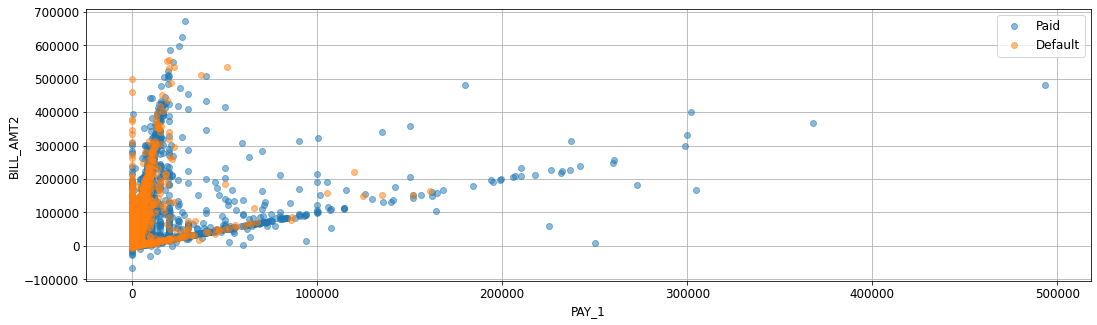

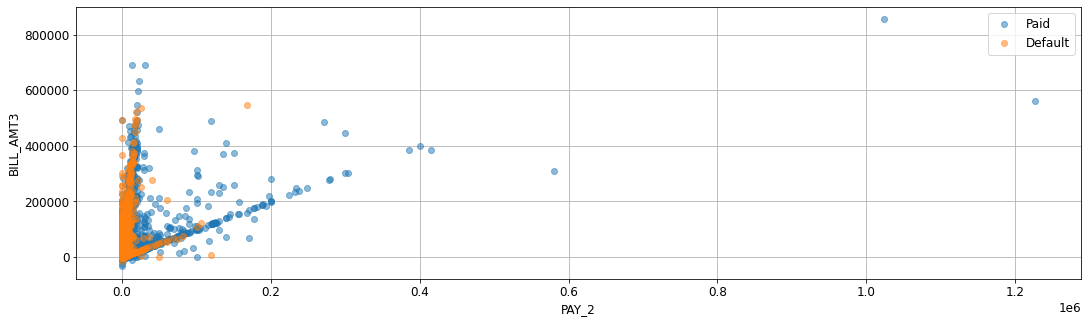

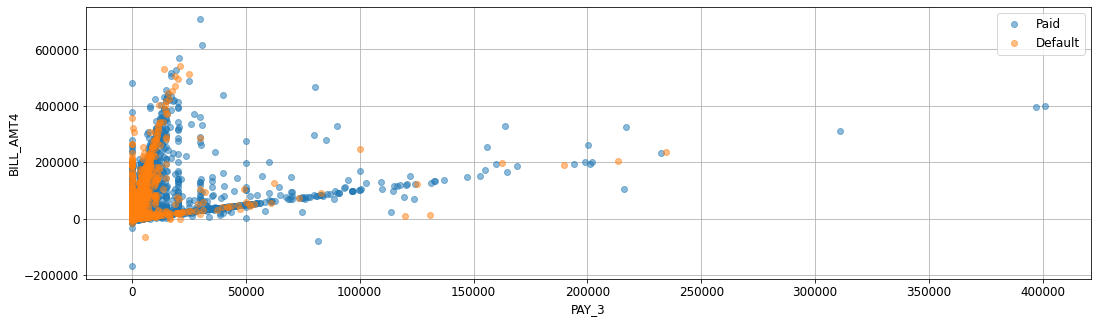

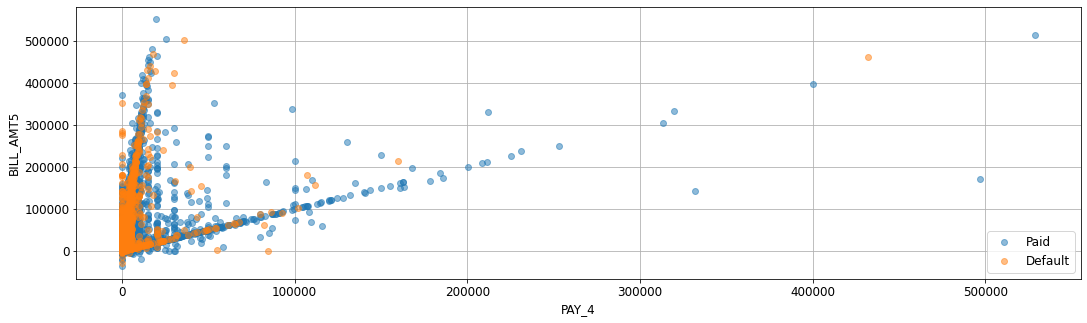

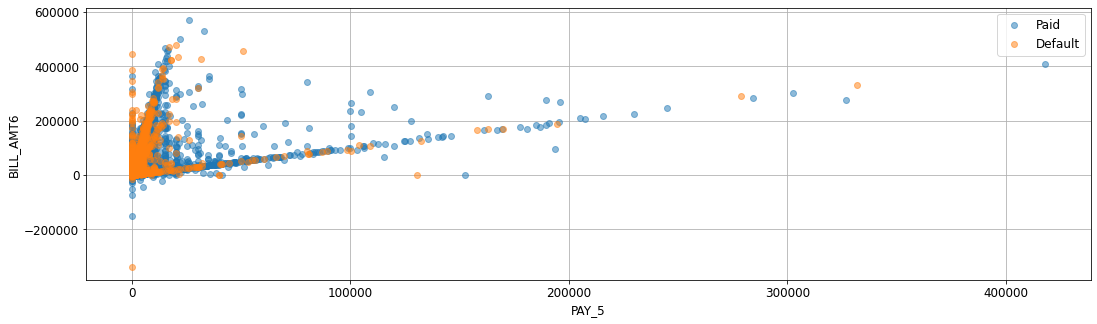

In [42]:
for i in range(1,6):
    paid.set_index(f"PAY_AMT{i}")[f'BILL_AMT{i+1}'].plot(marker='o', linestyle='', label='Paid', alpha=0.5)
    default.set_index(f"PAY_AMT{i}")[f'BILL_AMT{i+1}'].plot(marker='o', linestyle='', label='Default', alpha=0.5)
    plt.xlabel(f'PAY_{i}')
    plt.ylabel(f'BILL_AMT{i+1}')
    plt.legend();
    plt.show()

The thick line around 20 degrees are those that pay what they owe - mostly non default.
Another line arises that is steeper, representing those with large bills that aren't paid either in a lump sum or whose amount due is paid late.

Additionally, it seems like we don't have bad data, as most outliers are balanced between BILL and PAY.

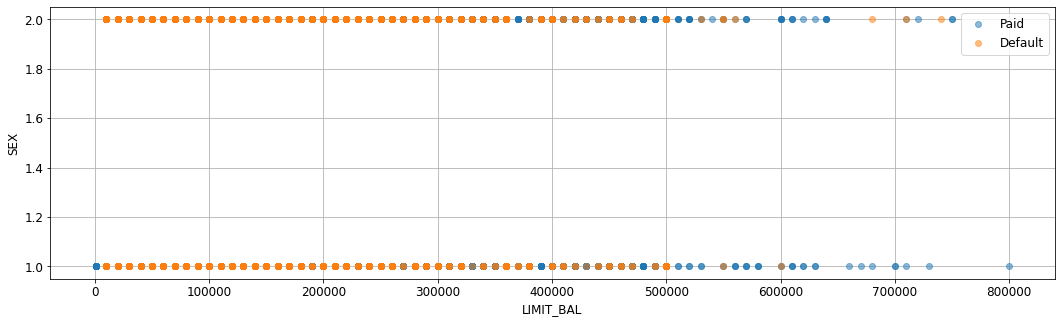

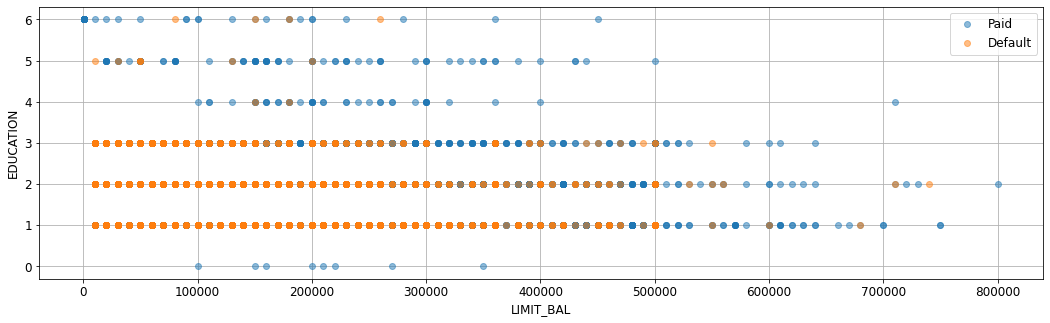

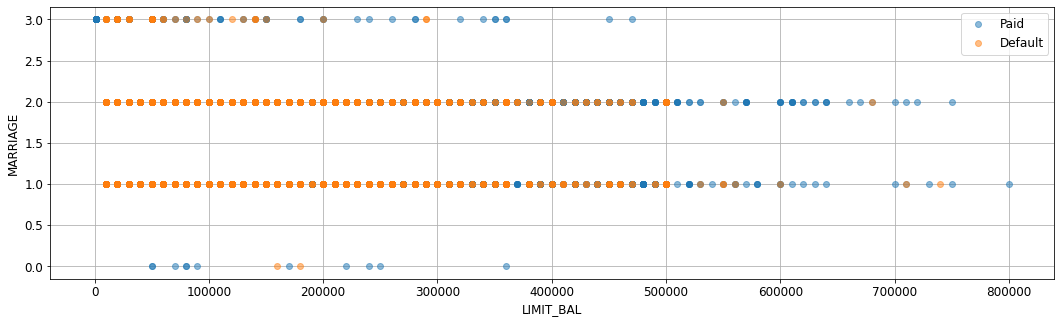

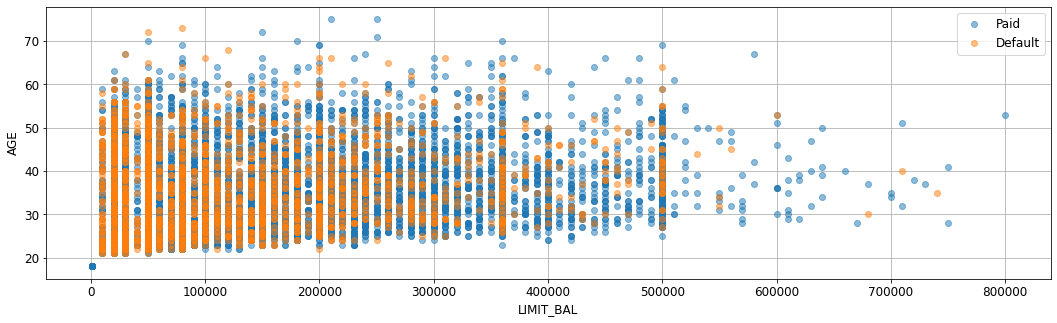

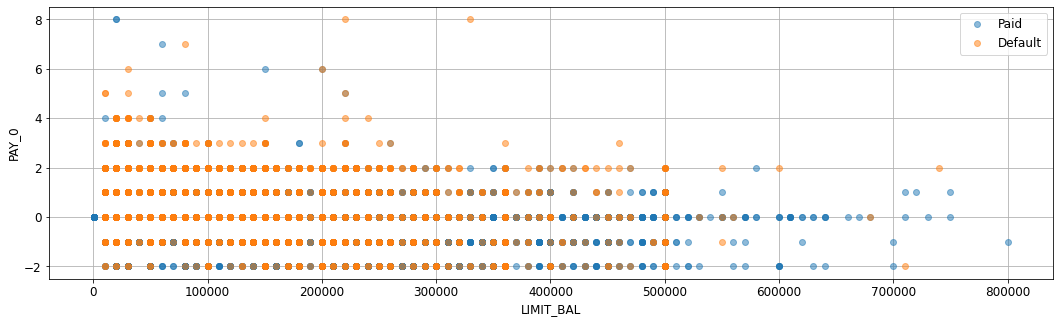

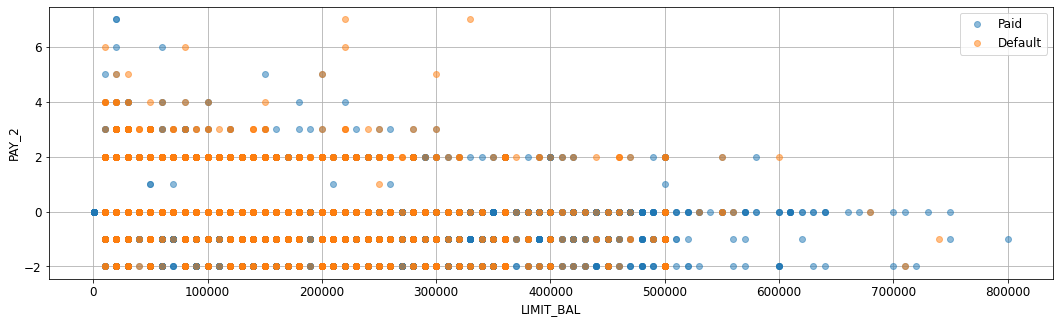

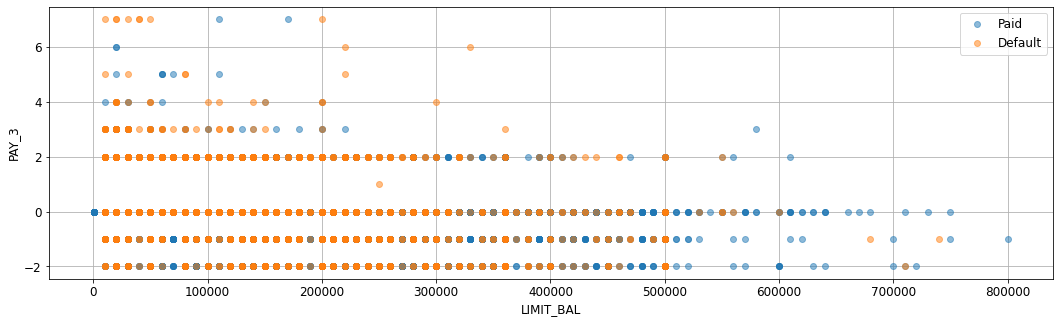

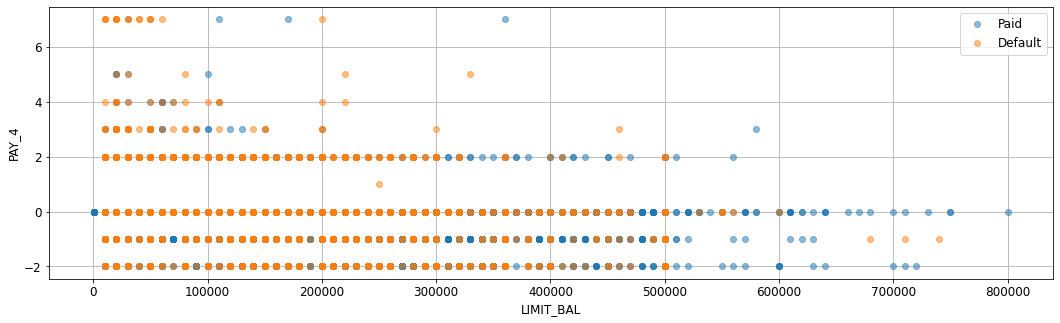

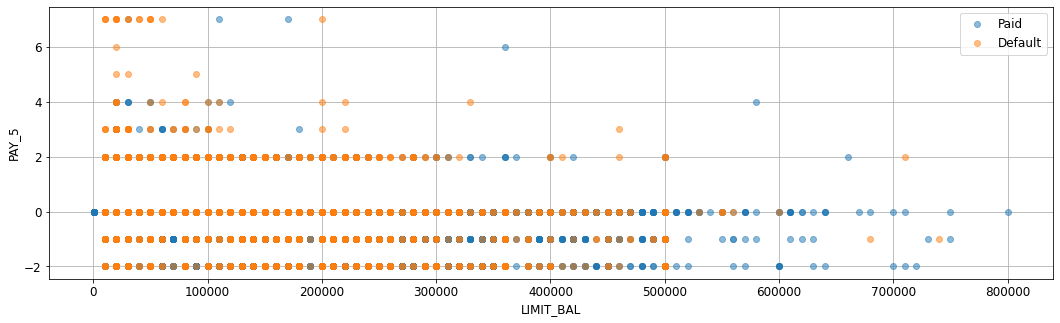

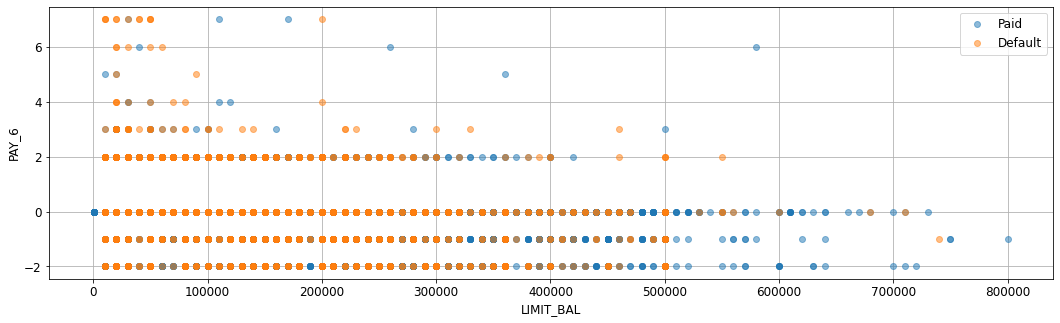

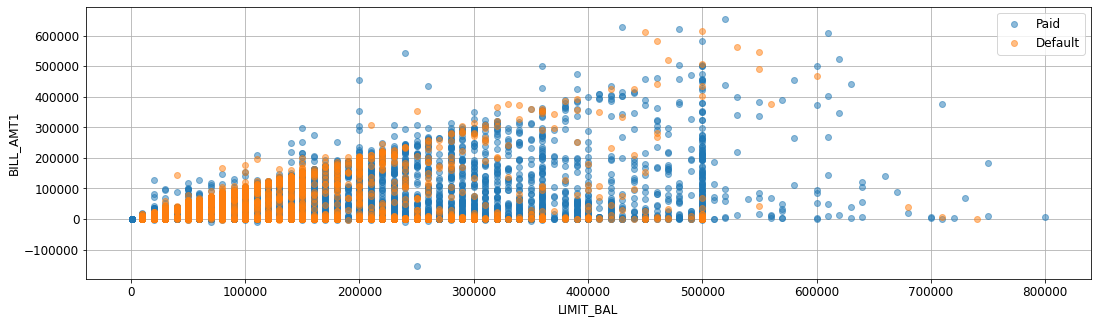

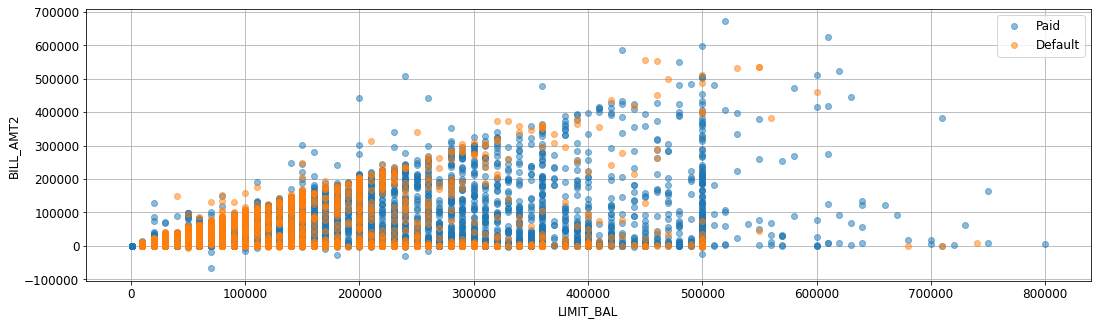

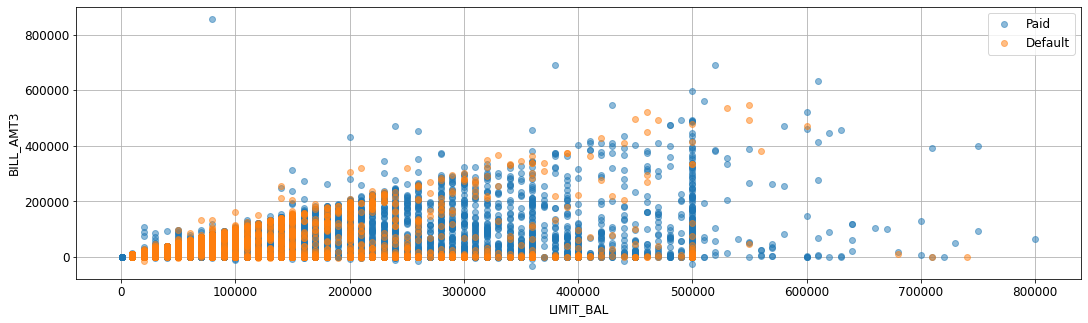

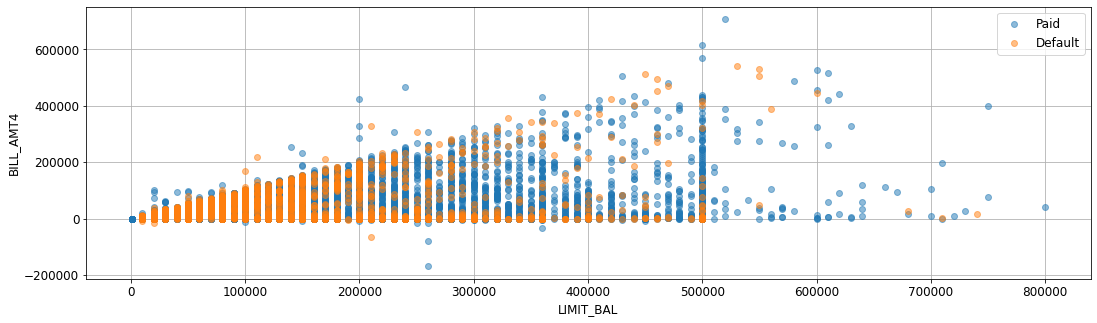

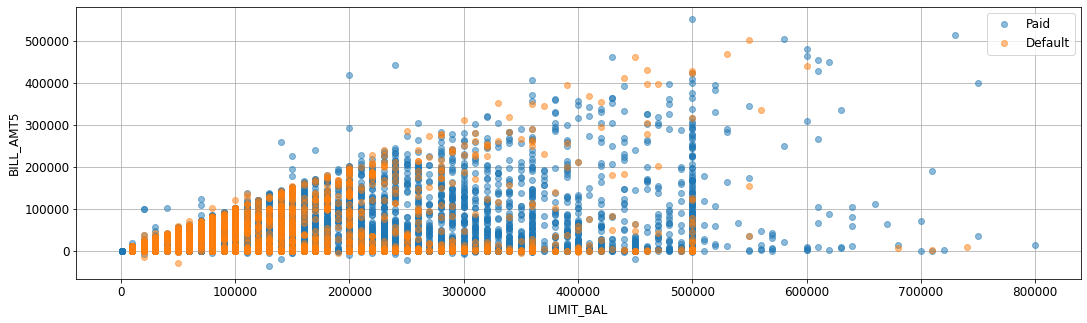

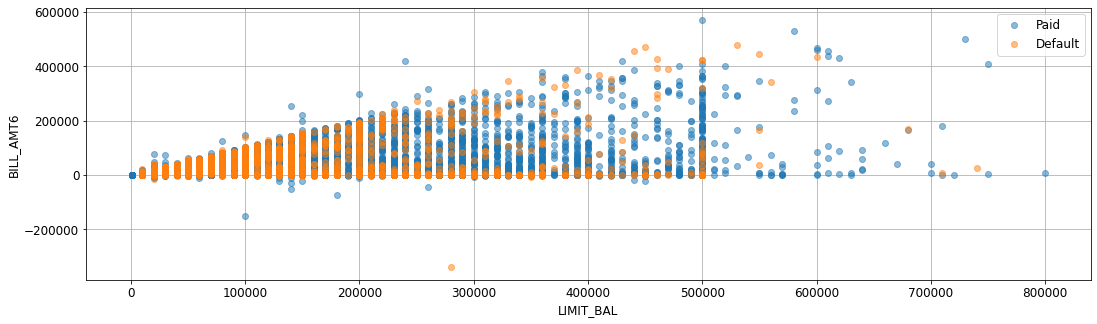

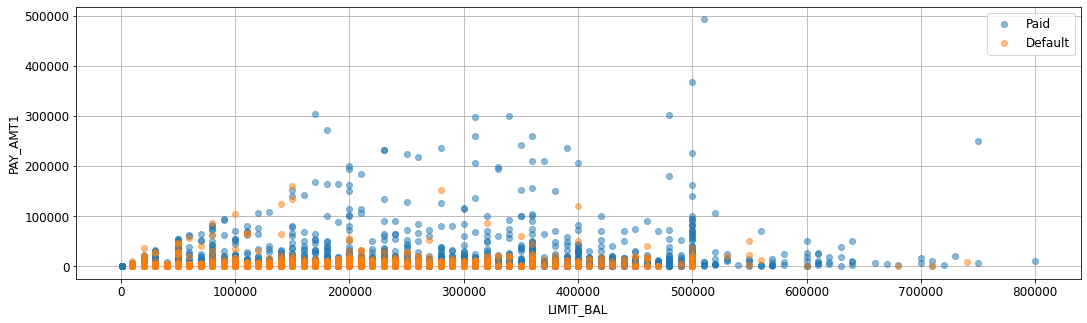

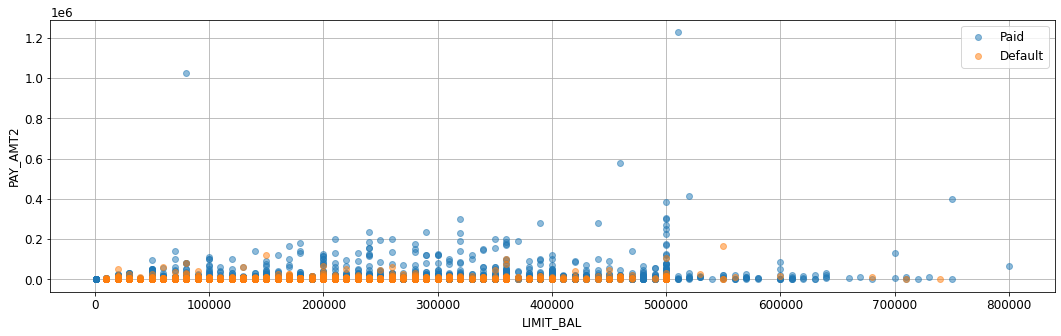

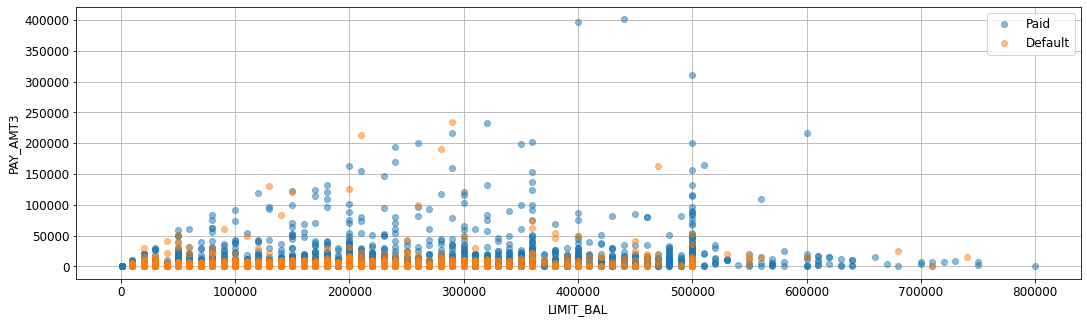

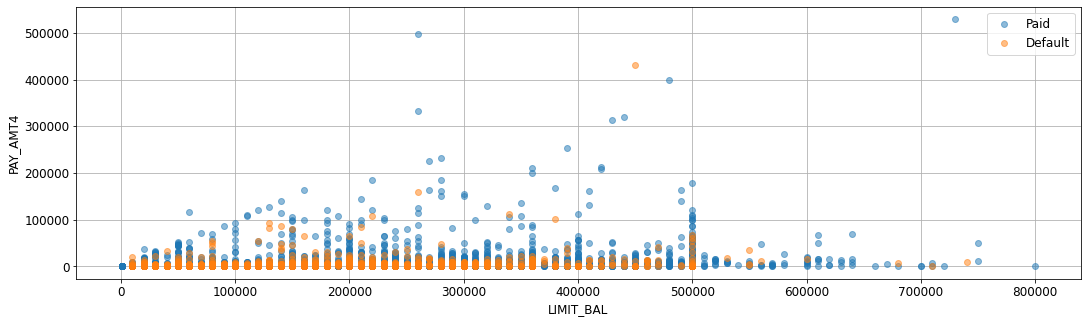

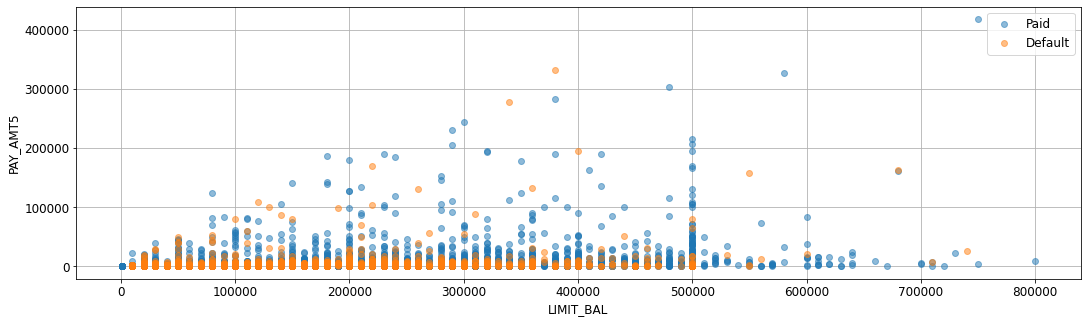

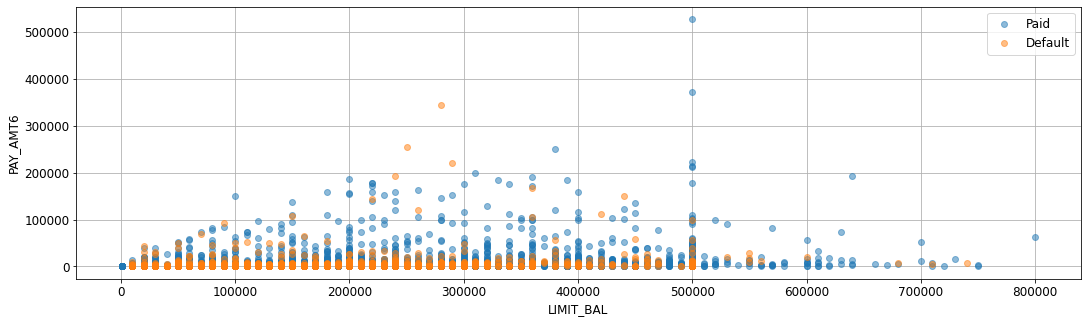

In [43]:
for i in paid.columns:
    if i == 'LIMIT_BAL' or i == 'PAY_1' or i == 'default':
        continue
    paid.set_index('LIMIT_BAL')[i].plot(marker='o', linestyle='', label='Paid', alpha=0.5)
    default.set_index(f"LIMIT_BAL")[i].plot(marker='o', linestyle='', label='Default', alpha=0.5)
    plt.xlabel(f'LIMIT_BAL')
    plt.ylabel(i)
    plt.legend();
    plt.show()

A few observations arise from these charts:
* Limit balances are capped at 500,000 for many.
* Some people have bills larger than their limits, but knowing that doesn't help in determining defaults.
* Higher limit balance leads to less default and viceversa.

# Some feature engineering before predictions

For a larger dataset we can use automatic feature engineering tools such as AutoFeat or FeatureTools,
but FeatureTools doesn't quite fit our needs because each individual has such a small amount of data, we can just do data aggregations manually.

We now generate features and see whether the features/transformations generated improve predictions.
We assess the latter by training a simple LGBMClassifier and assessing feature importances.

One thing to note is that the feature importances given by LGBMClassifier are given by the number of splits generated by a feature, which isn't always indicroc_auc_score(ytest, y_pred, average='weighted'))ative of the absolute best feature.

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
import gc

### Scoring
We measure the accuracy of our predictions by optimizing for a **recall-heavy F1 score**.

Accuracy measures how many observations, both positive and negative, were correctly classified. 
Because we care most about false positives - or cases when we say an account won't default but it does,
and there are fewer of these than non-defaults, we can't use simple accuracy scores.

Enter the F1 score - a combination of precision and recall. 
Since precision tells you how many positive identifications were correct and recall tells you what proportion of actual positives was identified correctly, we need to strike a balance between the two.

$$ F_1 = \frac{tp}{tp + \frac{1}{2} (fp + fn)} = \frac{precision \times recall}{precision + recall} $$

When setting the F-beta parameter, we will lean towards recall rather than precision, as one non-default card being classified as default is better than the other way around.  This will make us set a higher beta.

To measure the F1 score, we take the `roc_auc_score` - a measure of the f1 score under various threshold settings; thresholds 

In [47]:
def score(y_pred, ytest):
    cm = confusion_matrix(y_true = ytest, y_pred=y_pred)
    cmatrix = pd.DataFrame(data=cm, index=['Actual Non-Default', 'Actual Default'], 
                                     columns=['Predict Non-Default', 'Predict Default'])
    plt.figure(figsize=(10, 3))
    sns.heatmap(cmatrix, cmap='Blues', annot=True, fmt='d');
    print(classification_report(ytest, y_pred))
    try:
        print("ROC AUC Score: ", roc_auc_score(ytest, y_pred, average='weighted'))
    except:
        print("ROC AUC Score: ", 0)

              precision    recall  f1-score   support

       False       1.00      0.78      0.87     10000
        True       0.00      0.00      0.00         0

    accuracy                           0.78     10000
   macro avg       0.50      0.39      0.44     10000
weighted avg       1.00      0.78      0.87     10000

ROC AUC Score:  0


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


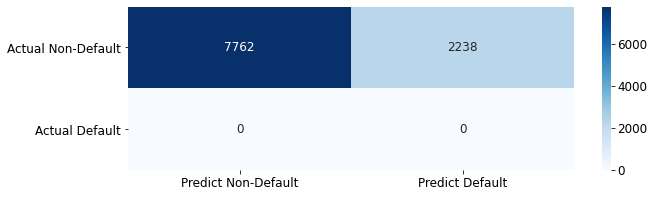

In [48]:
### Accuracy = 0.78
score(data['default'], [False]*len(data['default']))

In [49]:
def kfold_lightgbm(data, num_folds=5, stratified = True, debug= False, test_size=0.1):
    xtrain, xtest, ytrain, ytest = train_test_split(
                                                data.drop('default', axis=1),
                                                data['default'], 
                                                test_size = test_size, 
                                                stratify=data['default'],
                                                random_state = 8,
                                                shuffle=True)
    
    # Divide in training/validation and test data
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(xtrain.shape[0])
    sub_preds = np.zeros(xtest.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = xtrain.columns
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(xtrain, ytrain)):
        train_x, train_y = xtrain.iloc[train_idx], ytrain.iloc[train_idx]
        valid_x, valid_y = xtrain.iloc[valid_idx], ytrain.iloc[valid_idx]

        clf = LGBMClassifier(
            n_estimators=2000,
            learning_rate=0.1,
            num_leaves=123,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=15,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            nthread=4,
            is_unbalance=True
        )

        clf.fit(train_x, train_y, 
                eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', 
                verbose= 1000, 
                early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(xtest, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        fold_importance_df["accuracy"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()
        
    y_preds = sub_preds > 0.5
    score(y_preds, ytest)
    importances = display_importances(feature_importance_df)
    return clf, importances
        
# Display/plot feature importance
def display_importances(feats):
    cols = (feats[["feature", "importance"]].groupby("feature")
                                            .mean()
                                            .sort_values(by="importance", ascending=False)[:40]
                                            .index)
    best_features = feats.loc[feats.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    return best_features

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's auc: 0.924147	training's binary_logloss: 0.401732	valid_1's auc: 0.775386	valid_1's binary_logloss: 0.471657
Fold  1 AUC : 0.775386
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.917347	training's binary_logloss: 0.411078	valid_1's auc: 0.774958	valid_1's binary_logloss: 0.47204
Fold  2 AUC : 0.774958
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.913416	training's binary_logloss: 0.4

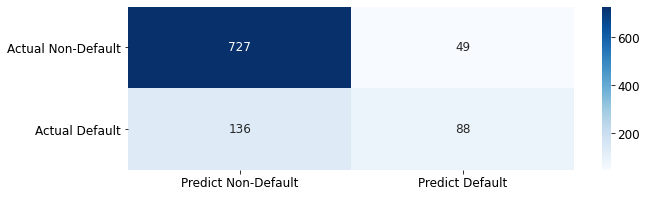

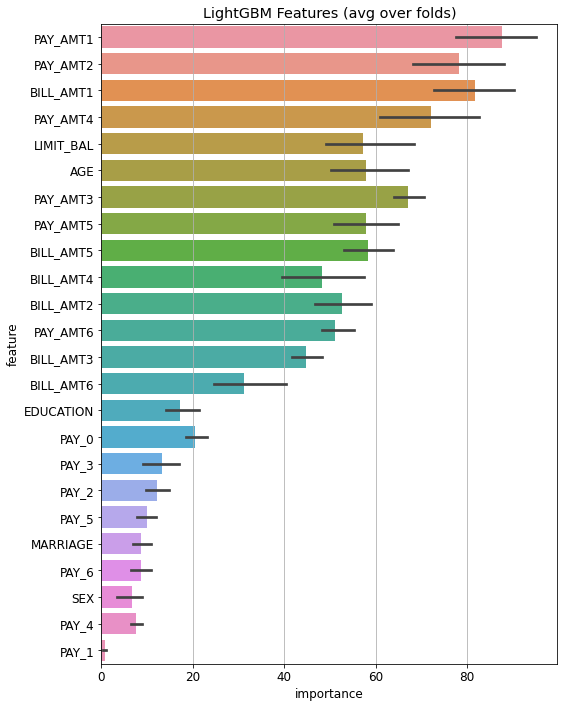

In [75]:
kfold_lightgbm(data);

In [51]:
from sklearn.preprocessing import StandardScaler

## Feature Engineering

For sake of avoiding data bias, we don't use SEX, MARRIAGE, or EDUCATION to make 
further features, as these could be discriminating against customers.
Therefore, we only use bills, payments, and payment delays.

In [136]:
pdata = data.copy()

In [137]:
pdata['MAX_PAY'] = pdata.filter(like='PAY_AMT').max(axis=1)
pdata['MIN_PAY'] = pdata.filter(like='PAY_AMT').min(axis=1)
pdata['AVE_PAY'] = pdata.filter(like='PAY_AMT').mean(axis=1)
pdata['STD_PAY'] = pdata.filter(like='PAY_AMT').std(axis=1)

pdata['MAX_BILL'] = pdata.filter(like='BILL').max(axis=1)
pdata['MIN_BILL'] = data.filter(like='BILL').min(axis=1)
pdata['AVE_BILL'] = pdata.filter(like='BILL').mean(axis=1)
pdata['STD_BILL'] = pdata.filter(like='BILL').std(axis=1)

pdata['NEVER_USED'] = (pdata.filter(regex='PAY_[0, 2-9]')==-2).all(axis=1).astype(int)
pdata['MONTHS_UNUSED'] = (pdata.filter(regex='PAY_[1-9]')==-2).sum(axis=1).astype(int)

pdata['NUM_LIMIT_BAL_BREACH'] = (pdata.filter(like='BILL_AM')
                                     .gt(pdata['LIMIT_BAL'], axis=0)).sum(axis=1)

pdata['NUM_PAID_EARLY'] = pdata.filter(like='BILL_AMT').lt(0, axis=0).sum(axis=1)

pdata['AMOUNT_BREACHED_5'] = (pdata['BILL_AMT5'] - (pdata['BILL_AMT6'] - pdata['PAY_AMT5'])) / pdata['LIMIT_BAL']
pdata['AMOUNT_BREACHED_4'] = (pdata['BILL_AMT4'] - (pdata['BILL_AMT5'] - pdata['PAY_AMT4'])) / pdata['LIMIT_BAL']
pdata['AMOUNT_BREACHED_3'] = (pdata['BILL_AMT3'] - (pdata['BILL_AMT4'] - pdata['PAY_AMT3'])) / pdata['LIMIT_BAL']
pdata['AMOUNT_BREACHED_2'] = (pdata['BILL_AMT2'] - (pdata['BILL_AMT3'] - pdata['PAY_AMT2'])) / pdata['LIMIT_BAL']
pdata['AMOUNT_BREACHED_1'] = (pdata['BILL_AMT1'] - (pdata['BILL_AMT2'] - pdata['PAY_AMT1'])) / pdata['LIMIT_BAL']

pdata['BREACH_AVE'] = pdata.filter(like='AMOUNT_BREACHED').mean(axis=1)
pdata['BREACH_MAX'] = pdata.filter(like='AMOUNT_BREACHED').max(axis=1)
pdata['BREACH_MIN'] = pdata.filter(like='AMOUNT_BREACHED').min(axis=1)
pdata['BREACH_STD'] = pdata.filter(like='AMOUNT_BREACHED').std(axis=1)

# Because larger PAY_ numbers indicate larger delay, we penalize a client based on
# how much they owe, and when they pay it.
pdata['DELAY_PENALTY_1'] = pdata['PAY_0'] * pdata['BILL_AMT1']
pdata['DELAY_PENALTY_2'] = pdata['PAY_2'] * pdata['BILL_AMT2']
pdata['DELAY_PENALTY_3'] = pdata['PAY_3'] * pdata['BILL_AMT3']
pdata['DELAY_PENALTY_4'] = pdata['PAY_4'] * pdata['BILL_AMT4']
pdata['DELAY_PENALTY_5'] = pdata['PAY_5'] * pdata['BILL_AMT5']
pdata['DELAY_PENALTY_6'] = pdata['PAY_6'] * pdata['BILL_AMT6']

#### Converting Features to Normal Distributions

Linear regressions tend to have a better chance at prediction when the features
are standard normal. We can do this by transforming some of our features.

The transformation we do is a [Box-Cox Test](https://itl.nist.gov/div898/handbook/eda/section3/eda336.htm),
which helps us convert the distribution to normal.  The Box-Cox test uses a parameter, lambda, to transform
log-distributed data containing zeros.  The best way to choose lambda is to correlate the transformed
distribution with a normal probability plot and pick the lambda that gives the highest correlation.

The features we'll transform are the BILL_AMTs and the PAY_AMTs. 
In order to not overfit, we'll select the same lambda for all columns.

In [138]:
x = pdata.filter(like='BILL')
x = x.where(x > 0, 0)
pdata.loc[:, pdata.filter(like='BILL').columns] = x

In [139]:
## Box Cox Transformation
lmbd = 0.2 
for col in pdata.filter(like='AMT').columns:
    pdata[col] = (pdata[col]+1.0).apply(lambda x: (x**lmbd-1)/lmbd )

## One-hot encoding of categorical features

In [140]:
pdata['SEX'] = pdata['SEX'].map({1:"male", 2:'female'})
pdata['EDUCATION'] = pdata['EDUCATION'].map({1:'grad_school', 
                                           2:'university', 
                                           3:'high_school', 
                                           4:'others', 
                                           5:'others', 
                                           6:'others'})
pdata['MARRIAGE'] = pdata['MARRIAGE'].map({1:'married', 2:'single', 3:'other'})
categorical = pd.get_dummies(pdata[['SEX', 'EDUCATION', 'MARRIAGE']])
pdata = pd.concat([pdata.drop(['MARRIAGE', 'SEX', 'EDUCATION'], axis=1), categorical], axis=1)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.94831	training's binary_logloss: 0.356291	valid_1's auc: 0.768795	valid_1's binary_logloss: 0.472092
Fold  1 AUC : 0.768795
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's auc: 0.947573	training's binary_logloss: 0.352559	valid_1's auc: 0.778391	valid_1's binary_logloss: 0.468934
Fold  2 AUC : 0.778391
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.93578	training's binary_logloss: 0.

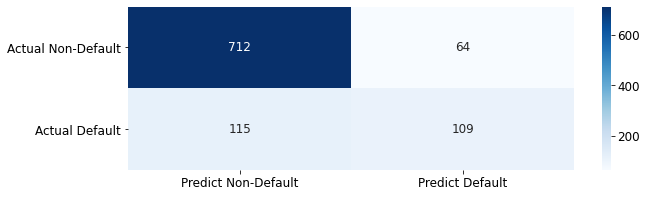

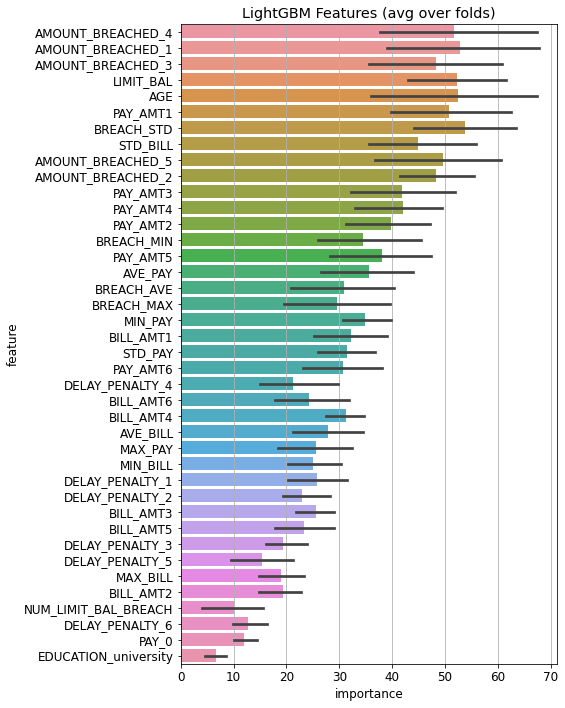

In [141]:
model = kfold_lightgbm(pdata)

# Dim Reduction

A good technique to extract the juice out of many features is to do dimensionality reduction.
Each new dimension represents a significant representation of the data.

We add these new dimensions to our main dataframe and see if our accuracy improves.

In [142]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
n_comps = 3
pca = PCA(n_components=n_comps)  #Considered only 3 components to put into 3 dimensions

In [143]:
scaler = StandardScaler()
X = scaler.fit_transform(pdata.drop('default', axis=1))
X_reduce = pca.fit_transform(X)
pcad = pd.DataFrame(X_reduce, index=range(1,10_001))
pcad.columns = [str(x+1)+"_pca" for x in pcad.columns]
pcad = pd.concat([pcad, data['default']], axis=1)

In [144]:
pcad[pcad['default']]

,1_pca,2_pca,3_pca,default
3,2.2970,-0.5529,-1.7177,True
5,-7.5756,1.0670,-1.8393,True
7,-4.9928,-0.5497,-0.5134,True
9,1.7436,-4.7532,0.2088,True
11,1.5410,1.5087,-0.7923,True
...,...,...,...,...
9975,-1.5707,1.0179,-0.1885,True
9981,-6.7970,-0.2062,-0.3399,True
9989,-0.1744,-3.7941,1.8690,True
9999,5.3319,-0.8698,-1.5567,True


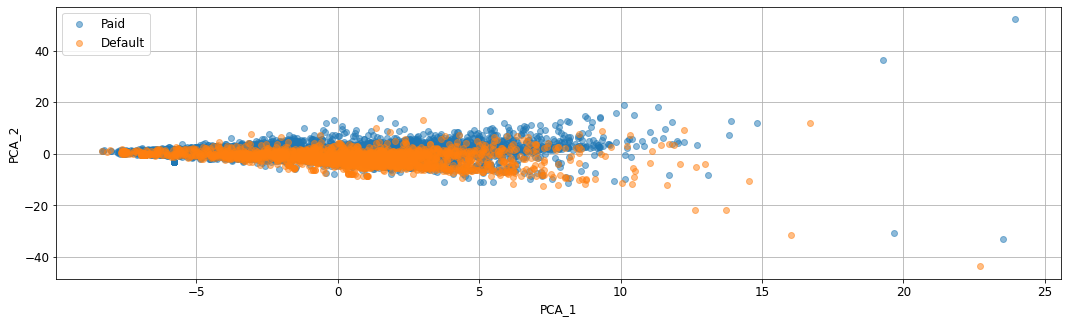

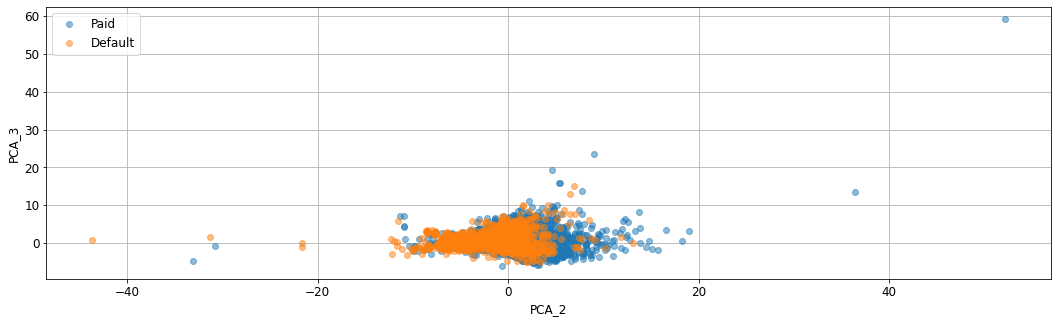

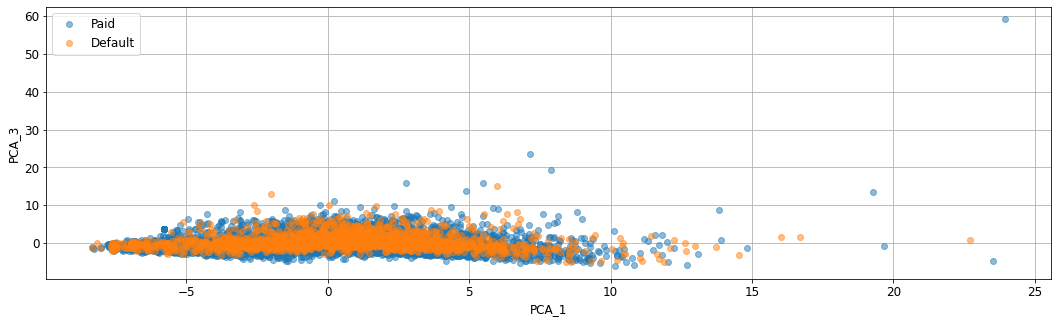

In [145]:
for (i, j) in ((1, 2), (2, 3), (1, 3)):
    pcad[~pcad['default']].set_index(f'{i}_pca')[f'{j}_pca'].plot(marker='o', linestyle='', label='Paid', alpha=0.5)
    pcad[pcad['default']].set_index(f'{i}_pca')[f'{j}_pca'].plot(marker='o', linestyle='', label='Default', alpha=0.5)
    plt.xlabel(f'PCA_{i}')
    plt.ylabel(f'PCA_{j}')
    plt.legend();
    plt.show()

There is some separation, mostly between PCA_2 and both PCA_1 and PCA_3, but nothing outstanding.

# Try UMAP 

Another dimensionality reduction technique is called UMAP.

In [146]:
import umap.umap_ as umap

In [147]:
reducer = umap.UMAP(random_state=42 ,n_components=n_comps, n_neighbors=50, min_dist = 0.1)
embedding = reducer.fit_transform(pdata.drop("default", axis=1))

In [148]:
ump = pd.DataFrame(embedding, index=range(1,10_001))
ump.columns = [str(x+1)+"_umap" for x in ump.columns]
ump = pd.concat([ump, data['default']], axis=1)

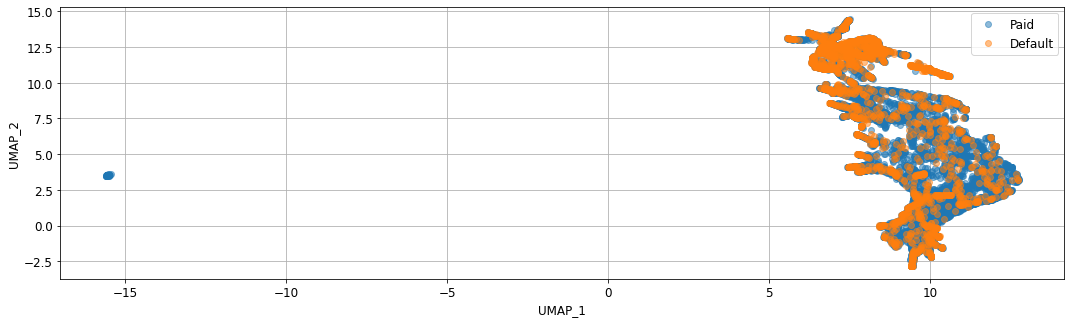

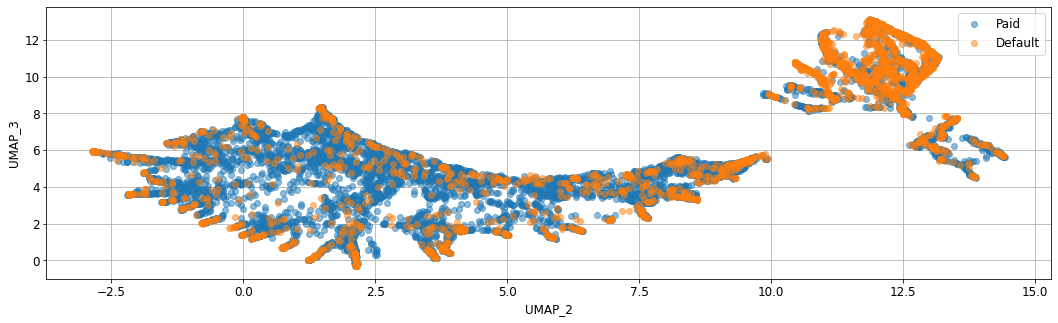

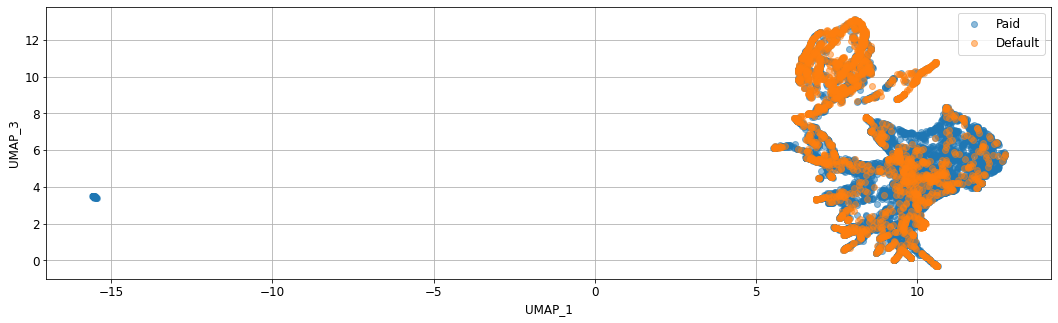

In [149]:
for (i, j) in ((1, 2), (2, 3), (1, 3)):
    ump[~ump['default']].set_index(f'{i}_umap')[f'{j}_umap'].plot(marker='o', linestyle='', label='Paid', alpha=0.5)
    ump[ump['default']].set_index(f'{i}_umap')[f'{j}_umap'].plot(marker='o', linestyle='', label='Default', alpha=0.5)
    plt.xlabel(f'UMAP_{i}')
    plt.ylabel(f'UMAP_{j}')
    plt.legend();
    plt.show()

Not as good as expected, but UMAP_2 vs. UMAP_3 does show some nice separation of colors...

# Try LDA

In [150]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [151]:
lda = LDA(n_components=1).fit_transform(pdata.drop('default', axis=1), data['default'])
lda = pd.DataFrame(lda, index=range(1, 10_001))
lda.columns = ['lda']

<AxesSubplot:xlabel='lda', ylabel='1_pca'>

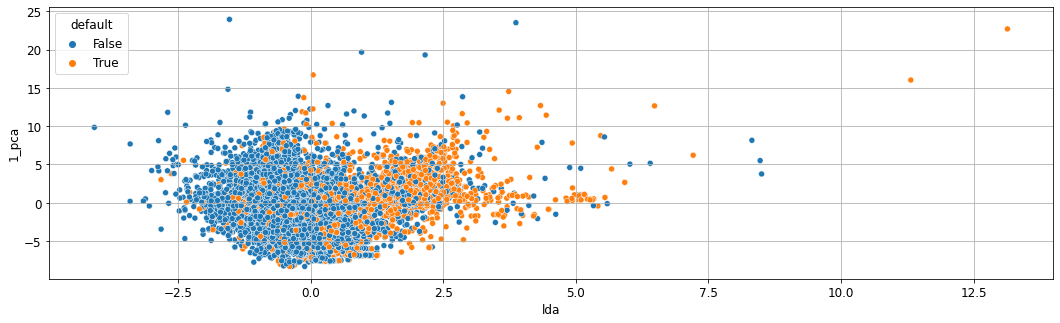

In [152]:
sns.scatterplot(x=lda['lda'], y=pcad['1_pca'], hue=data['default'])

### How correlated are these features?

<AxesSubplot:>

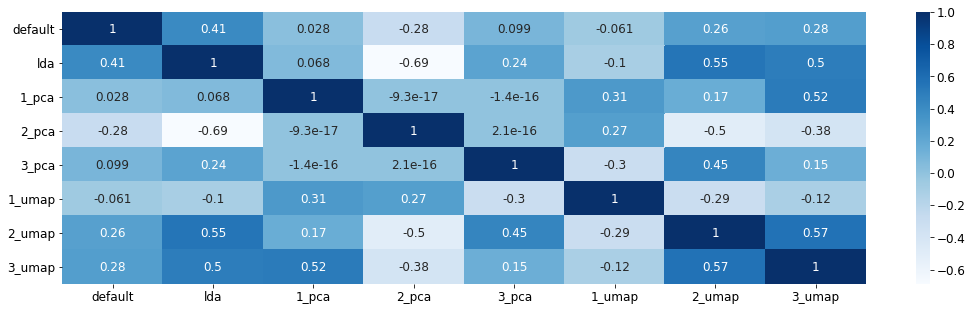

In [153]:
sns.heatmap(pd.concat([
           data['default'],
           lda, 
           pcad.drop('default', axis=1),
           ump.drop('default', axis=1)], axis=1).corr(), cmap='Blues', annot=True)

In [154]:
dimredux = pd.concat([pdata, 
                      lda, 
                      pcad.drop('default', axis=1),
                      ump.drop('default', axis=1)], axis=1)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.93191	training's binary_logloss: 0.395567	valid_1's auc: 0.766657	valid_1's binary_logloss: 0.472473
Fold  1 AUC : 0.766657
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.943392	training's binary_logloss: 0.36497	valid_1's auc: 0.776354	valid_1's binary_logloss: 0.465973
Fold  2 AUC : 0.776354
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.931668	training's binary_logloss: 0.3

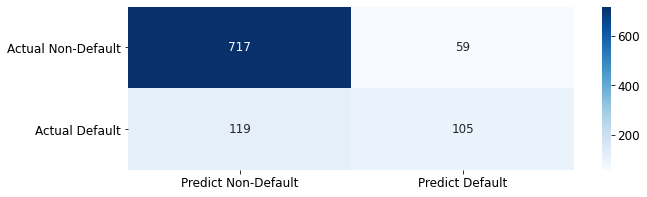

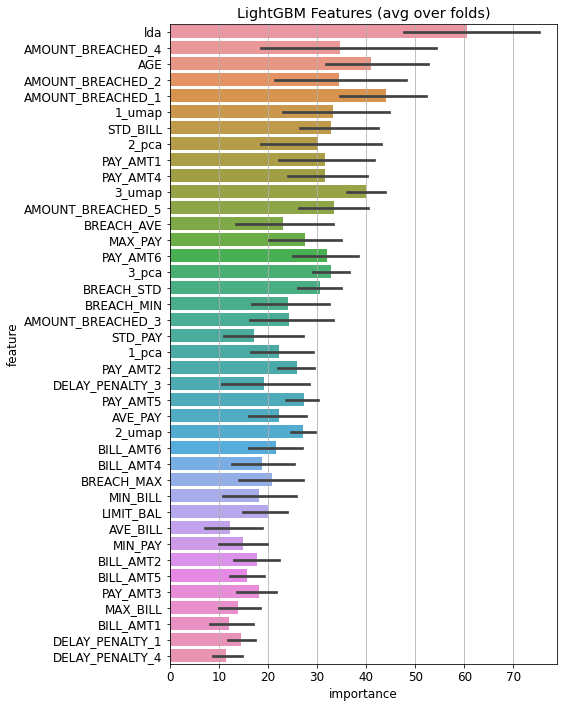

In [155]:
model, features = kfold_lightgbm(dimredux)

In [156]:
cols = (features[["feature", "importance"]].groupby("feature")
                                        .mean()
                                        .sort_values(by="importance", ascending=False)[:40]
                                        .index)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.92453	training's binary_logloss: 0.402736	valid_1's auc: 0.763091	valid_1's binary_logloss: 0.478277
Fold  1 AUC : 0.763091
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.929317	training's binary_logloss: 0.390103	valid_1's auc: 0.762859	valid_1's binary_logloss: 0.475035
Fold  2 AUC : 0.762859
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.921511	training's binary_logloss: 0.

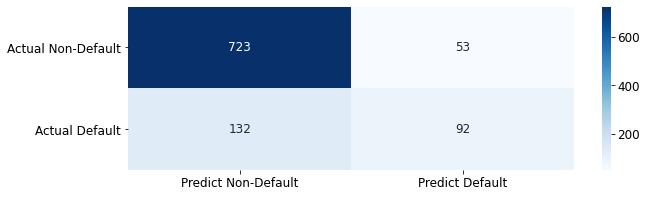

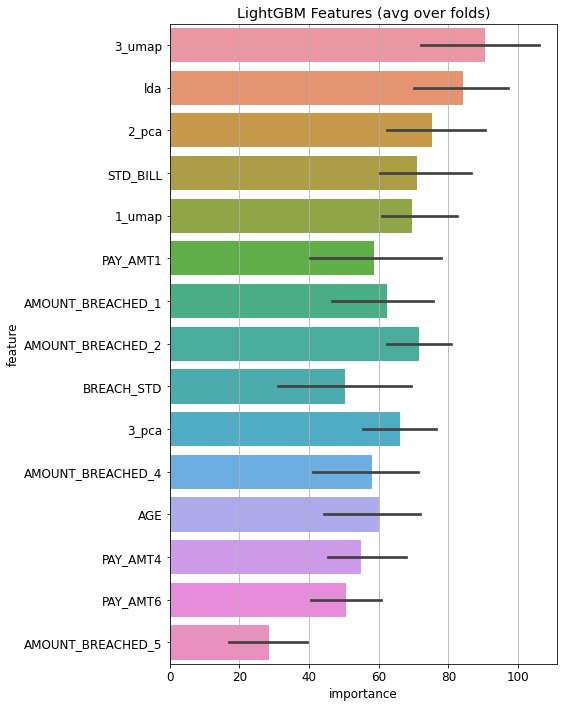

In [157]:
# What if we take the top 15 features only?
kfold_lightgbm(dimredux[list(cols[:15]) + ['default']]);

Doesn't work. What if we only take lda as it is the feature most correlated to the target?

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.935873	training's binary_logloss: 0.390356	valid_1's auc: 0.75641	valid_1's binary_logloss: 0.477987
Fold  1 AUC : 0.756410
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.939931	training's binary_logloss: 0.376631	valid_1's auc: 0.777392	valid_1's binary_logloss: 0.466316
Fold  2 AUC : 0.777392
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's auc: 0.915092	training's binary_logloss: 0.

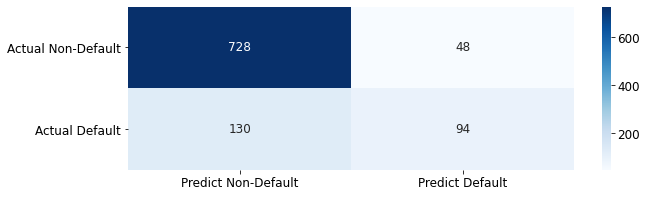

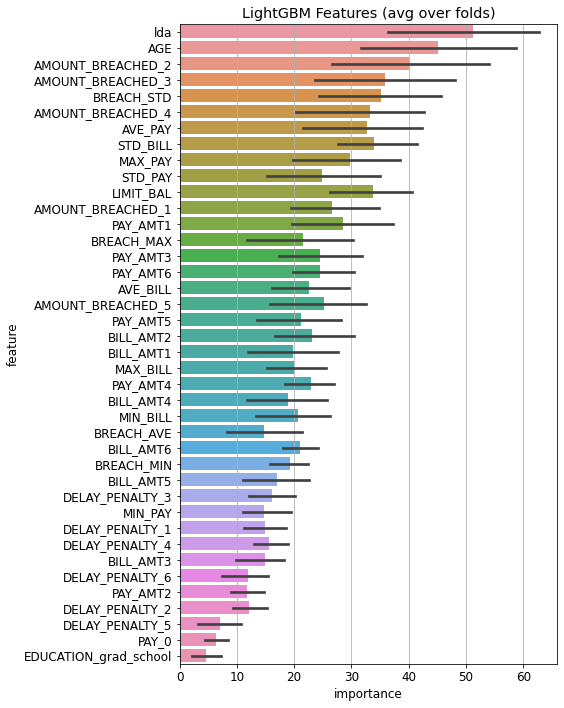

In [163]:
model = kfold_lightgbm(pd.concat([pdata, lda], axis=1))

There is no improvement. All the information captured in the pca/lda is already taken into account
by the gradient boosting tree. 
Therefore, we only pass the best dataset - the one with the manually engineered features which has the highest accuracy and roc auc score.

# Ready for Production
We'll pass all of these features on to the model development phase to see if better models helps with accuracy
and are capable of exploiting these features.

In [164]:
pdata.to_csv('../dataset/processed_data.csv')